In [20]:
import math
import copy
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import clear_output, display
from statsmodels.tsa.seasonal import STL
sns.set(style="darkgrid")
%config IPCompleter.greedy = True
%config Completer.use_jedi = False
sns.mpl.rc('figure',figsize=(20, 6))

In [46]:
pd.options.mode.chained_assignment = None 

def mean_range(data, start, end):
    past_start = pd.Timestamp(start) - pd.Timedelta(days=1)
    past_end = pd.Timestamp(end) - pd.Timedelta(days=1)
    future_start = pd.Timestamp(start) + pd.Timedelta(days=1)
    future_end = pd.Timestamp(end) + pd.Timedelta(days=1)
    new_vals = data.loc[past_start:past_end]['count'].values + data.loc[future_start:future_end]['count'].values / 2
    data.loc[start:end]['count'] = new_vals
    return data

In [21]:
%run 8.1-forecasting-methods.ipynb

In [22]:
data_load_second_interval = 5
minute_interval = 1

In [23]:
resample_second_interval = 60 * 15

In [24]:
forecast_minutes = 180

In [25]:
forecast_observations = 3 * 4

In [26]:
resample_minutes = resample_second_interval / 60

In [27]:
hour_observations = int(60/resample_minutes)
half_hour_observations = int(hour_observations/2)
day_observations = int(hour_observations*24)
three_day_observations = int(day_observations*3)
week_observations = int(day_observations*7)

# Peak split into temporar largest and remainder categories #

In [28]:
data = pd.read_csv(f"../../data/corrected_m2/corrected_data_2_{minute_interval}m_{data_load_second_interval}s.csv")
data['ndt'] = pd.to_datetime(data['ndt'])

In [29]:
peaks = pd.read_csv(f"../../data/peaks/peaks.csv")

In [30]:
peak_data = data[data['hash'].isin(peaks['hash'])].groupby(['hash','ndt']).sum()

In [31]:
peak_data = peak_data.groupby([pd.Grouper(level='hash'), pd.Grouper(freq=f'{resample_second_interval}S', level=-1)]).sum().fillna(0)

In [32]:
peak_data_ndt = data[data['hash'].isin(peaks['hash'])].groupby(['ndt','hash']).sum()

In [33]:
peak_data_ndt = peak_data_ndt.groupby([pd.Grouper(freq=f'{resample_second_interval}S', level=0), pd.Grouper(level='hash')]).sum().fillna(0)

In [34]:
timespan_start = data['ndt'].min()
timespan_end = pd.Timestamp('2019-07-20 08:42:00')

In [35]:
timespan_end - timespan_start

Timedelta('37 days 01:42:00')

In [36]:
training_timespan = pd.date_range(start=timespan_start, end='2019-07-20 08:42:00', freq=f'{resample_second_interval}S')
total_timespan = pd.date_range(start=timespan_start, end='2019-08-05 05:59:00', freq=f'{resample_second_interval}S')

In [37]:
observation_window = 60*30 # minutes
n_largest_peaks = 10

# 10 min, 10 peaks
# 4 min 10 peaks
# 6 min 10
# 8 min 10


# Size of the training sample considered, useful for debuggig
## : int(60/resample_second_interval*60*24*3) --> 3 days only  
## : len(training_timespan) --> 100% of the training set
## : len(total_timespan) --> 100% of the data
timespan_considered = len(total_timespan)

## First peak-selection method - strict real-time 

In [17]:
largest_peaks_through_time = []
emerging_peaks_through_time = []
largest_count_through_time = []
remaining_count_through_time = []

for step in total_timespan[:timespan_considered]:
    window_end = step
    window_start = window_end - np.timedelta64(observation_window, 's')
    
    clear_output(wait=True)
    print(f"Window of: {window_start} - {window_end}",end='\r')
    window_groupby = peak_data_ndt.loc[window_start:window_end].groupby('hash') 
    window_sums = window_groupby.sum()
    largest_peaks = window_sums.nlargest(n_largest_peaks, 'count')

    try:
        current_step_count = peak_data_ndt.loc[step]
        largest_count = current_step_count[current_step_count.index.isin(largest_peaks.index)].sum().values[0]
        removed_index = current_step_count.index.isin(largest_peaks.index)# | current_step_count.index.isin(emerging_growth.index)
        remaining_count = current_step_count[~removed_index].sum().values[0]
    except KeyError as e:
        largest_count = largest_count
        remaining_count = remaining_count
    
    largest_peaks_through_time.append(largest_peaks.index)
    largest_count_through_time.append(largest_count)
    remaining_count_through_time.append(remaining_count)

In [18]:
largest_peaks_through_time = pd.DataFrame(largest_peaks_through_time, index=total_timespan[:timespan_considered], columns=[f"l{x}" for x in range(1,n_largest_peaks+1)])
largest_peaks_through_time['count'] = pd.Series(largest_count_through_time, index=total_timespan[:timespan_considered])
remaining_count_through_time = pd.DataFrame(remaining_count_through_time, index=total_timespan[:timespan_considered], columns=['count'])

In [45]:
anomaly_free_remaining = remaining_count_through_time.copy()

In [47]:
anomaly_free_remaining = mean_range(anomaly_free_remaining, '2019-07-22 12:30:00','2019-07-22 12:45:00')
anomaly_free_remaining = mean_range(anomaly_free_remaining, '2019-07-22 08:00:00','2019-07-22 08:00:00')
anomaly_free_remaining = mean_range(anomaly_free_remaining, '2019-07-22 13:45:00','2019-07-22 13:45:00')
anomaly_free_remaining = mean_range(anomaly_free_remaining, '2019-07-24 13:00:00','2019-07-24 13:00:00')
anomaly_free_remaining = mean_range(anomaly_free_remaining, '2019-07-29 12:15:00','2019-07-29 12:45:00')
anomaly_free_remaining = mean_range(anomaly_free_remaining, '2019-08-01 13:00:00','2019-08-01 14:15:00')
anomaly_free_remaining = mean_range(anomaly_free_remaining, '2019-08-02 14:15:00','2019-08-02 14:45:00')

In [54]:
#remaining_count_through_time.to_csv('../../data/peaks/remaining_count_15.csv')
#largest_peaks_through_time.to_csv('../../data/peaks/largest_peaks_15.csv')

In [43]:
remaining_count_through_time = pd.read_csv('../../data/peaks/remaining_count_15.csv', index_col=0, parse_dates=True)
largest_peaks_through_time = pd.read_csv('../../data/peaks/largest_peaks_15.csv', index_col=0, parse_dates=True)

In [59]:
training_split = len(remaining_count_through_time.loc[:training_timespan[-1]])

In [23]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(20, 8)

largest_peaks_through_time[:three_day_observations]['count'].resample('1800S').sum().plot(ax=ax)
remaining_count_through_time[:three_day_observations]['count'].resample('1800S').sum().plot(ax=ax)
peak_data.groupby('ndt').sum()[:three_day_observations].resample('1800S').sum().plot(ax=ax)
ax.legend(['largest','remaining','total'])

In [24]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(20, 8)
peak_data.groupby('ndt').sum()[:three_day_observations].plot(ax=ax)
remaining_count_through_time[:three_day_observations].plot(ax=ax)
ax.legend(['Total','Remaining']) 

In [25]:
largest_peaks_first_week = []
for column in largest_peaks_through_time:
    if(column != "count"):
        largest_peaks_first_week.extend(largest_peaks_through_time[column][:week_observations].unique())
largest_peaks_first_week = pd.Series(largest_peaks_first_week).dropna().unique()

In [26]:
series_interval_id = []
first_occurance = []
last_occurance = []

for series in largest_peaks_first_week:
    largest = False
    
    for peak in largest_peaks_through_time[:week_observations].iterrows():
        found = (series in peak[1].values)
        if(not largest):
            # Isn't tracked
            if(found):
                # Start tracking
                series_interval_id.append(series)
                first_occurance.append(peak[0])
                largest = True
        else:
            # Is tracked
            if(not found and largest):
                # Stop tracking
                largest = False
                last_occurance.append(peak[0] - pd.Timedelta(resample_second_interval, 's'))
    if(largest):
        largest = False
        last_occurance.append(peak[0] - pd.Timedelta(resample_second_interval, 's'))

In [27]:
occurance_intervals = pd.DataFrame()
occurance_intervals['series'] = series_interval_id
occurance_intervals['start'] = first_occurance
occurance_intervals['end'] = last_occurance

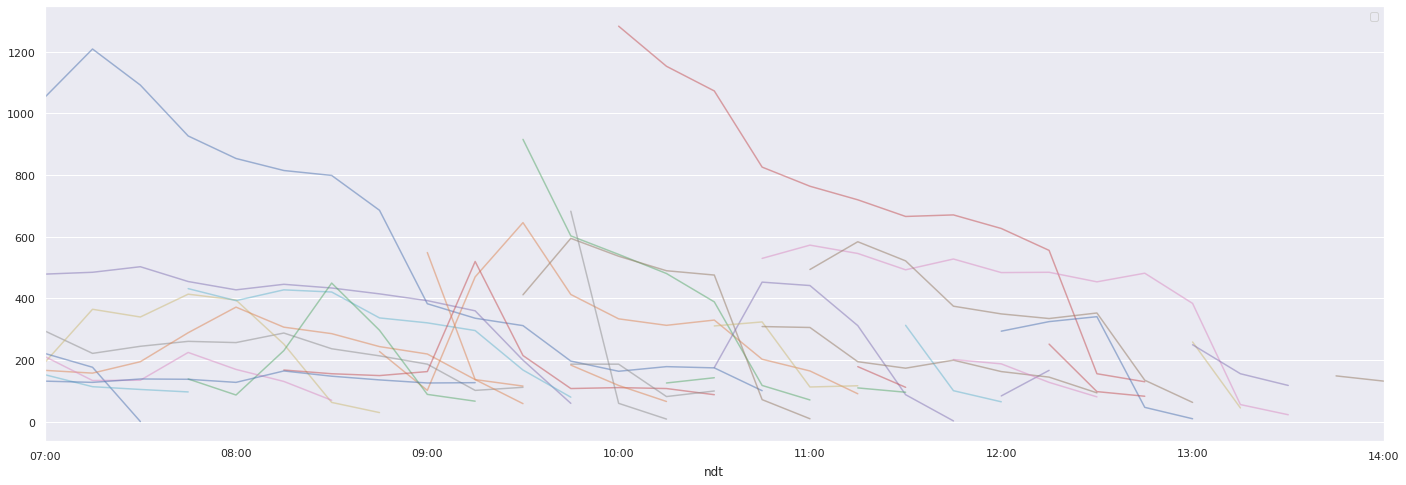

In [28]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 8)

for peak in occurance_intervals[occurance_intervals['end'] <= '2019-06-13 14:00:00'].iterrows():
    if (peak[1][1]!=peak[1][2]):
        plot_data = peak_data.loc[peak[1][0]][peak[1][1]:peak[1][2]]
        if (len(plot_data) > 0):
            plot_data.plot(ax=ax, alpha=0.5)
ax.legend([])

## Second peak-selection method - new series aware 

In [29]:
class TrackedSeries():
    
    def __init__(self, series_id):
        self.id = series_id
        self.protected_time = 1 # Number of steps until it can be replaced

        
class SeriesTracker():
    
    def __init__(self, data, maximum_series = 5):
        self.data = data
        self.tracked = {}
        self.maximum_series = maximum_series
        self.window_size = 1
        self.removed = []
        #self.current_series = 0
        
    def step_forward(self, target_time):
        '''Assuming target_time is one unit ahead from current time.
           Could verify, won't do.
        '''
        self.current_time = target_time
        for series_id in self.tracked:
            self.tracked[series_id].protected_time -= 1
            
    def full(self):
        return len(self.data == self.maximum_series)
    
    def remove_series(self, series_to_remove):
        if (series_to_remove in self.tracked):
            self.tracked.pop(series_to_remove)
    
    def clear_observed(self, considered_series):
        new_series = []
        for series in considered_series:
            if (series not in self.removed):
                new_series.append(series)
        self.removed.clear()
        return np.array(new_series)
    
    def add_series(self, series_id, current_requests):
        if(series_id in self.removed):
            return False
        
        if(series_id not in self.tracked):
            if(len(self.tracked) < self.maximum_series):
                # Add
                self.tracked[series_id] = TrackedSeries(series_id)
                #print("Adding free", series_id)
                return True
            else:
                # The number of series being tracked is at max, can we replace some series?
                replacable = []
                for tracked in self.tracked.values():
                    # Is the series touchable?
                    if(tracked.protected_time <= 0):
                        # The series can be replaced
                        replacable.append(tracked.id)

                # Determine which should be removed
                if(len(replacable) > 0):
                    window_start = self.current_time - np.timedelta64(self.window_size * 60, 's')
                    window_sums = self.data.loc[window_start:self.current_time].groupby('hash').sum() 
                    replacable_sums = window_sums.reindex(index = replacable).fillna(0)
                    least_significant = replacable_sums.nsmallest(1, 'count')#.index[0]
                    # Is the replaced value less significant?
                    if(least_significant.values[0][0] <= current_requests):
                        self.tracked.pop(least_significant.index[0])
                        self.removed.append(least_significant.index[0])
                        self.tracked[series_id] = TrackedSeries(series_id)
                        return True
                    return False
                else:
                    #print("Failed to add", series_id)
                    # No series can be removed, failed to add
                    return False
        # The series is already tracked
        #print("Already tracked", series_id)
        return True

In [30]:
speculated_largest_peaks = []
for col in largest_peaks_through_time.drop(columns=['count']):
    speculated_largest_peaks.extend(largest_peaks_through_time[col].unique())
speculated_largest_peaks = pd.Series(speculated_largest_peaks).dropna().unique()

In [31]:
speculative_tracked_through_time = []
speculative_tracked_count = []
speculative_largest = []
speculative_largest_count = []
speculative_remaining_count_through_time = []

series_tracker = SeriesTracker(peak_data_ndt)
considered_largest_peaks = speculated_largest_peaks

for step in total_timespan[:timespan_considered]:
    window_end = step
    window_start = window_end - np.timedelta64(observation_window, 's')
    
    clear_output(wait=True)
    print(f"Window of: {window_start} - {window_end}",end='\r')
    
    window_groupby = peak_data_ndt.loc[window_start:window_end].groupby('hash') 
    window_sums = window_groupby.sum()
    
    # Select 5 largest-window series
    largest_peaks = window_sums.nlargest(5, 'count')
    #  Set tracking time
    series_tracker.step_forward(step)
    
    for series in largest_peaks.index.values:
        series_tracker.remove_series(series)
    
    try:
        # Current step data
        current_step_count = peak_data_ndt.loc[step]        
        # Select the 5 largest from the data and sum
        largest_count = current_step_count[current_step_count.index.isin(largest_peaks.index)].sum().values[0]
        # Current step index without the accounted for largest
        removed_index = current_step_count.index.isin(largest_peaks.index)
        # Search for speculative large series
        current_step_largest_removed = current_step_count.loc[~removed_index]
        # Indexes matching previously observed
        current_step_speculative = current_step_largest_removed.loc[current_step_largest_removed.index.isin(considered_largest_peaks)].index
        
        # Try and add series to tracking
        for series in current_step_speculative:
            result = series_tracker.add_series(series, current_step_count.loc[series]['count'])
            # No series can be added
            if (result != True):
                break
        
        # Cleanup peaks from consideration
        considered_largest_peaks = series_tracker.clear_observed(considered_largest_peaks)
        
        # Tracked series
        tracked_series = np.array([x for x in series_tracker.tracked])
        # Tracked series count
        tracked_count = current_step_largest_removed[current_step_largest_removed.index.isin(tracked_series)].sum()[0]
        # Remainder count
        remaining_count = current_step_largest_removed[~current_step_largest_removed.index.isin(tracked_series)].sum()[0]        
    except KeyError as e:
        largest_count = largest_count
        tracked_count = tracked_count
        remaining_count = remaining_count
    
    speculative_tracked_through_time.append(tracked_series)
    speculative_tracked_count.append(tracked_count)
    speculative_remaining_count_through_time.append(remaining_count)
    speculative_largest.append(largest_peaks.index.values)
    speculative_largest_count.append(largest_count)

In [32]:
speculative_tracked_through_time = pd.DataFrame(speculative_tracked_through_time, index=total_timespan[:timespan_considered], columns=[f"s{x}" for x in range(1,5+1)])
speculative_tracked_through_time['s-count'] = pd.Series(speculative_tracked_count, index=total_timespan[:timespan_considered])
speculative_tracked_through_time = speculative_tracked_through_time.join(pd.DataFrame(speculative_largest, index=total_timespan[:timespan_considered], columns=[f"l{x}" for x in range(1,5+1)]))
speculative_tracked_through_time['l-count'] = pd.Series(speculative_largest_count, index=total_timespan[:timespan_considered])
speculative_remaining_count_through_time = pd.DataFrame(speculative_remaining_count_through_time, index=total_timespan[:timespan_considered], columns=['count'])

In [50]:
anomaly_free_remaining_speculative = speculative_remaining_count_through_time.copy()

In [51]:
anomaly_free_remaining_speculative = mean_range(anomaly_free_remaining_speculative, '2019-07-22 12:30:00','2019-07-22 12:45:00')
anomaly_free_remaining_speculative = mean_range(anomaly_free_remaining_speculative, '2019-07-22 08:00:00','2019-07-22 08:00:00')
anomaly_free_remaining_speculative= mean_range(anomaly_free_remaining_speculative, '2019-07-22 13:45:00','2019-07-22 13:45:00')
anomaly_free_remaining_speculative = mean_range(anomaly_free_remaining_speculative, '2019-07-24 13:00:00','2019-07-24 13:00:00')
anomaly_free_remaining_speculative = mean_range(anomaly_free_remaining_speculative, '2019-07-29 12:15:00','2019-07-29 12:45:00')
anomaly_free_remaining_speculative = mean_range(anomaly_free_remaining_speculative, '2019-08-01 13:00:00','2019-08-01 14:15:00')
anomaly_free_remaining_speculative = mean_range(anomaly_free_remaining_speculative, '2019-08-02 14:15:00','2019-08-02 14:45:00')

In [53]:
#speculative_remaining_count_through_time.to_csv('../../data/peaks/speculative_remaining_count_15.csv')
#speculative_tracked_through_time.to_csv('../../data/peaks/speculative_largest_peaks_15.csv')

In [49]:
speculative_remaining_count_through_time = pd.read_csv('../../data/peaks/speculative_remaining_count_15.csv', index_col=0, parse_dates=True)
speculative_tracked_through_time = pd.read_csv('../../data/peaks/speculative_largest_peaks_15.csv', index_col=0, parse_dates=True)

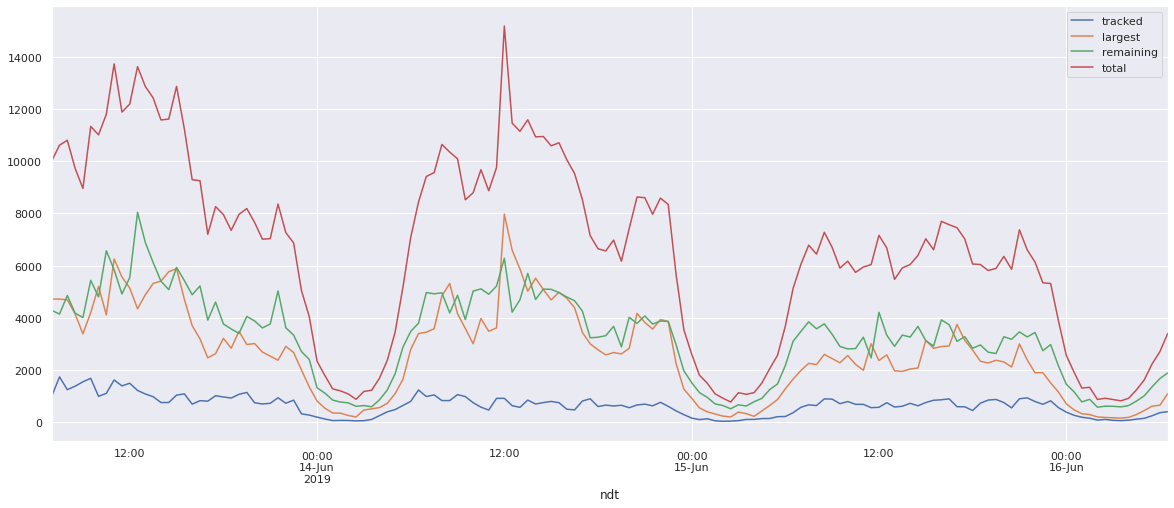

In [36]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(20, 8)

speculative_tracked_through_time[:three_day_observations]['s-count'].resample('1800S').sum().plot(ax=ax)
speculative_tracked_through_time[:three_day_observations]['l-count'].resample('1800S').sum().plot(ax=ax)
speculative_remaining_count_through_time[:three_day_observations]['count'].resample('1800S').sum().plot(ax=ax)
peak_data.groupby('ndt').sum()[:three_day_observations].resample('1800S').sum().plot(ax=ax)
ax.legend(['tracked','largest','remaining','total'])

In [37]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(20, 8)
peak_data.groupby('ndt').sum()[:three_day_observations].plot(ax=ax)
speculative_remaining_count_through_time[:three_day_observations].plot(ax=ax)
ax.legend(['Total','Remaining']) 

In [38]:
tracked_peaks_first_week = []
for column in speculative_tracked_through_time:
    if(column != "s-count" and column != "l-count"):
        tracked_peaks_first_week.extend(speculative_tracked_through_time[column][:week_observations].unique())
tracked_peaks_first_week = pd.Series(tracked_peaks_first_week).dropna().unique()

In [39]:
series_interval_id = []
first_occurance = []
last_occurance = []

for series in tracked_peaks_first_week:
    largest = False
    
    for peak in speculative_tracked_through_time[:week_observations].iterrows():
        found = (series in peak[1].values)
        if(not largest):
            # Isn't tracked
            if(found):
                # Start tracking
                series_interval_id.append(series)
                first_occurance.append(peak[0])
                largest = True
        else:
            # Is tracked
            if(not found and largest):
                # Stop tracking
                largest = False
                last_occurance.append(peak[0] - pd.Timedelta(resample_second_interval, 's'))
    if(largest):
        largest = False
        last_occurance.append(peak[0] - pd.Timedelta(resample_second_interval, 's'))

In [40]:
tracked_occurance_intervals = pd.DataFrame()
tracked_occurance_intervals['series'] = series_interval_id
tracked_occurance_intervals['start'] = first_occurance
tracked_occurance_intervals['end'] = last_occurance

In [41]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 8)

for peak in tracked_occurance_intervals[tracked_occurance_intervals['end'] <= '2019-06-13 14:00:00'].iterrows():
    if (peak[1][1]!=peak[1][2]):
        plot_data = peak_data.loc[peak[1][0]][peak[1][1]:peak[1][2]]
        if (len(plot_data) > 0):
            plot_data.plot(ax=ax, alpha=0.5)
ax.legend([])

# Forecasting remainder #

In [19]:
import copy

## First peak-selection method - strict real-time 

### TBATS

In [23]:
from tbats import TBATS

In [24]:
fm_tbats_mod = TBATS(seasonal_periods=[day_observations], use_box_cox=False)

In [25]:
fm_tbats_res = fm_tbats_mod.fit(remaining_count_through_time[:training_split])

In [26]:
fm_tbats_res.summary()

'Use Box-Cox: False\nUse trend: True\nUse damped trend: True\nSeasonal periods: [96.]\nSeasonal harmonics [6]\nARMA errors (p, q): (0, 0)\nSmoothing (Alpha): 0.799466\nTrend (Beta): -0.178289\nDamping Parameter (Phi): 0.800000\nSeasonal Parameters (Gamma): [ 2.44758990e-08 -1.57377931e-07]\nAR coefficients []\nMA coefficients []\nSeed vector [1254.84089382   17.43043386 -348.93090485  219.56247761  221.69781304\n   26.44522082   87.06911985   10.01950302  922.98822192  402.20737465\n -109.72995698   94.57753543   87.12005869  -43.65185883]\n\nAIC 72583.268593'

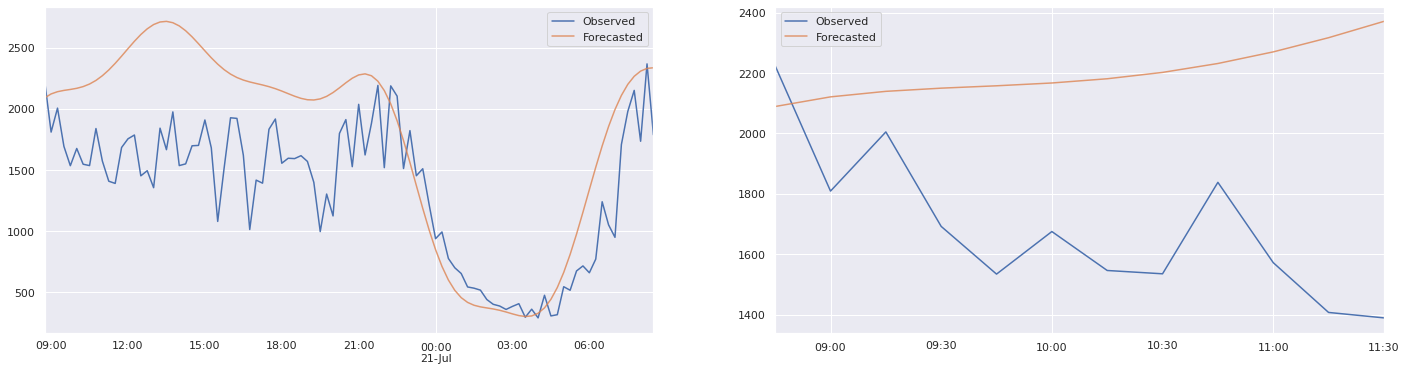

In [27]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
ax[0].set_title("24 Hours")
ax[1].set_title("3 Hour")
showcase_zoom(remaining_count_through_time[training_split:training_split+day_observations], pd.Series(fm_tbats_res.forecast(day_observations)), ax[0])
showcase_zoom(remaining_count_through_time[training_split:training_split+forecast_observations], pd.Series(fm_tbats_res.forecast(forecast_observations)), ax[1])

In [28]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
remaining_count_through_time[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

vis_tbats = copy.deepcopy(fm_tbats_res)

pd.Series(vis_tbats.forecast(forecast_observations), index=remaining_count_through_time.index[training_split:training_split+forecast_observations]).plot(ax=ax, alpha=0.6)
for i in range(1, day_observations+1): # 24 hour ahead
    vis_tbats.fit(remaining_count_through_time[:training_split+i])
    pd.Series(vis_tbats.forecast(forecast_observations), index=remaining_count_through_time.index[training_split+i:training_split+i+forecast_observations]).plot(ax=ax, alpha=0.5)
ax.set_title(f"\"Live\" - {forecast_minutes} Minutes ahead forecasts as new observations are added.")

Text(0.5, 1.0, '"Live" - 180 Minutes ahead forecasts as new observations are added.')

In [29]:
_, tbats_forecasts_fm = forecast_n_steps(remaining_count_through_time, copy.deepcopy(fm_tbats_res), training_split, forecast_observations)

In [30]:
#tbats_forecasts_fm.to_csv('../../data/forecasts/peaks_rt_tbats_forecasts_15.csv')

In [31]:
tbats_forecasts_fm = pd.read_csv('../../data/forecasts/peaks_rt_tbats_forecasts_15.csv', index_col=0, parse_dates=True)

### ARIMA with Fourier Terms

In [39]:
from pmdarima.preprocessing import FourierFeaturizer
import pmdarima as pm

In [40]:
resulting_models = []
for d_k in range(1, 12):
        daily_transformation = FourierFeaturizer(m=day_observations, k=d_k)
        _, exog_d = daily_transformation.fit_transform(remaining_count_through_time[:training_split])
        print(d_k)
        ft_fit = pm.auto_arima(remaining_count_through_time[:training_split],
                             start_q = 2,
                             max_q = 20,
                             start_p = 2,
                             max_p = 20,
                             D = None,
                             exogenous=exog_d,
                             max_order = 30,
                             seasonal = False,
                             information_criterion = 'aic',
                             stepwise = True, # n_jobs = 16
                             trace = 2,
                             cov_type=None
                            )
        resulting_models.append(ft_fit)

1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=53909.188, Time=1.18 sec
First viable model found (53909.188)
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=89723.099, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=54080.374, Time=0.35 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=60488.017, Time=2.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=53906.388, Time=2.14 sec
New best model found (53906.388 < 53909.188)
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=58478.478, Time=4.77 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=53918.695, Time=1.66 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=53907.998, Time=2.40 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=57248.532, Time=5.14 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=53802.821, Time=6.13 sec
New best model found (53802.821 < 53906.388)
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=53945.548, Time=0.77 sec
Near non-invertible roots for order (3, 0, 1)(0, 0, 0, 0); setting score to inf (at least o

In [42]:
smallest_aic = min(resulting_models, key=lambda x: x.aic())

In [43]:
smallest_aic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3559
Model:               SARIMAX(3, 0, 3)   Log Likelihood              -26769.088
Date:                Fri, 05 Mar 2021   AIC                          53576.176
Time:                        20:50:22   BIC                          53693.543
Sample:                             0   HQIC                         53618.027
                               - 3559                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
FOURIER_S96-0   900.0344     68.493     13.141      0.000     765.791    1034.278
FOURIER_C96-0  -406.2369     95.985     -4.232      0.000    -594.365    -218.109
FOURIER_S96-1   429.9255     79.413      5.414      0.000     274.279     585.572
FOURIER_C96-1   168.4208     74.229      2.269      0.023      22.934     313.907
FOURIER_S96-2   -61.2353     70.639     -0.867      0.386    -199.684      77.214
FOURIER_C96-2   241.5181     66.951      3.607      0.000     110.296     372.740
FOURIER_S96-3   101.6830     60.837      1.671      0.095     -17.555     220.921
FOURIER_C96-3     2.8352     54.466      0.052      0.958    -103.917     109.587
FOURIER_S96-4   113.9805     45.734      2.492      0.013      24.344     203.617
FOURIER_C96-4    55.2450     47.163      1.171      0.241     -37.193     147.683
FOURIER_S96-5   -33.2971     31.064     -1.072      0.284     -94.181      27.587
FOURIER_C96-5    25.8816     32.288      0.802      0.423     -37.402      89.165
ar.L1             0.9714      0.087     11.103      0.000       0.800       1.143
ar.L2             0.6657      0.155      4.285      0.000       0.361       0.970
ar.L3            -0.6372      0.069     -9.284      0.000      -0.772      -0.503
ma.L1            -0.3088      0.087     -3.550      0.000      -0.479      -0.138
ma.L2            -0.7965      0.093     -8.553      0.000      -0.979      -0.614
ma.L3             0.1415      0.014     10.003      0.000       0.114       0.169
sigma2         2.026e+05   1894.545    106.947      0.000    1.99e+05    2.06e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             94414.31
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                             1.12
Prob(H) (two-sided):                  0.03   Kurtosis:                        28.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.67e+14. Standard errors may be unstable.
"""

In [44]:
print(smallest_aic, smallest_aic.aic())

 ARIMA(3,0,3)(0,0,0)[0]           53576.175656032756


In [ ]:
# K = 6

### Selected model

In [63]:
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.api import SARIMAX

In [64]:
fourier_dp = DeterministicProcess(anomaly_free_remaining.index, period=day_observations, fourier=6)
exog_fourier = fourier_dp.in_sample()

In [65]:
exog_fourier = exog_fourier.append(
                fourier_dp.out_of_sample(forecast_observations,
                                       forecast_index=pd.date_range(
                                               start=exog_fourier.index[-1]+pd.Timedelta(minutes=15),
                                               periods=forecast_observations,
                                               freq=f"{resample_second_interval}S")))

In [66]:
arimax_mod = SARIMAX(anomaly_free_remaining[:training_split], order=(3, 0, 3), exog=exog_fourier[:training_split], trend='c')
arimax_res = arimax_mod.fit()
print(arimax_res.summary())

/home/jakub/.conda/envs/bp_thesis_pyr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
/home/jakub/.conda/envs/bp_thesis_pyr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                 3559
Model:               SARIMAX(3, 0, 3)   Log Likelihood              -26781.079
Date:                Wed, 07 Apr 2021   AIC                          53602.157
Time:                        19:43:55   BIC                          53725.702
Sample:                    06-13-2019   HQIC                         53646.211
                         - 07-20-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    290.8355    163.016      1.784      0.074     -28.669     610.340
sin(1,96)    924.6969    162.219      5.700      0.000     606.754    1242.640
cos(1,96)   -346.4238    170.425     -2.033      0.0

In [36]:
#joblib.dump(arimax_res, open(f'../../models/arimax_peaks_{minute_interval}_{resample_second_interval}', 'wb'))

In [37]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
ax[0].set_title("24 Hours")
ax[1].set_title("3 Hour")
showcase_zoom(remaining_count_through_time[training_split:training_split+day_observations],
              pd.Series(arimax_res.forecast(
                    day_observations,
                    exog=exog_fourier[training_split:training_split+day_observations])),
              ax[0])
showcase_zoom(remaining_count_through_time[training_split:training_split+forecast_observations],
              pd.Series(arimax_res.forecast(
                    forecast_observations,
                    exog=exog_fourier[training_split:training_split+forecast_observations])),
              ax[1])

In [67]:
arimax_timestamps = []
arimax_forecasts_rt = []
for step in range(training_split, len(anomaly_free_remaining)):
    clear_output(wait=True)
    print("Step: ", step + 1, "-", len(anomaly_free_remaining), "; %:", (step + 1)/len(anomaly_free_remaining), end='\r')
    data_extended = anomaly_free_remaining[step:step+1]
    arimax_timestamps.append(data_extended.index[0])
    arimax_res = arimax_res.append(data_extended, exog=exog_fourier[step:step+1])
    forecast_exog = exog_fourier[step:step+forecast_observations]
    arimax_forecasts_rt.append(arimax_res.forecast(min(forecast_observations, len(forecast_exog)), exog=forecast_exog).values)
arimax_forecasts_rt = pd.DataFrame(index=arimax_timestamps, data=arimax_forecasts_rt, columns=[f"step_{x}" for x in range(1, forecast_observations+1)])
del arimax_timestamps

In [40]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
remaining_count_through_time[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

for forecast in arimax_forecasts_rt[:day_observations].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=forecast_minutes),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)
ax.set_title(f"\"Live\" - {forecast_minutes} Minutes ahead forecasts as new observations are added.")

Text(0.5, 1.0, '"Live" - 180 Minutes ahead forecasts as new observations are added.')

In [68]:
#arimax_forecasts_rt.to_csv('../../data/forecasts/peaks_rt_arimax_forecasts_15.csv')

In [49]:
arimax_forecasts_rt = pd.read_csv('../../data/forecasts/peaks_rt_arimax_forecasts_15.csv', index_col=0, parse_dates=True)

## Second peak-selection method - Speculative 

### TBATS

In [216]:
from tbats import TBATS

In [217]:
fm_tbats_mod = TBATS(seasonal_periods=[day_observations], use_box_cox=False)

In [218]:
fm_tbats_res = fm_tbats_mod.fit(speculative_remaining_count_through_time[:training_split])

In [219]:
fm_tbats_res.summary()

'Use Box-Cox: False\nUse trend: True\nUse damped trend: True\nSeasonal periods: [96.]\nSeasonal harmonics [6]\nARMA errors (p, q): (0, 0)\nSmoothing (Alpha): 0.790120\nTrend (Beta): -0.176275\nDamping Parameter (Phi): 0.800000\nSeasonal Parameters (Gamma): [-1.53224429e-09 -1.38779060e-07]\nAR coefficients []\nMA coefficients []\nSeed vector [1398.87494328   19.63025849 -383.08304082  212.11124974  223.94609727\n   22.32089429   88.35178488   15.35984232 1003.57835633  431.23966337\n -125.08513204   99.2291371    85.01739877  -44.72427212]\n\nAIC 73314.298753'

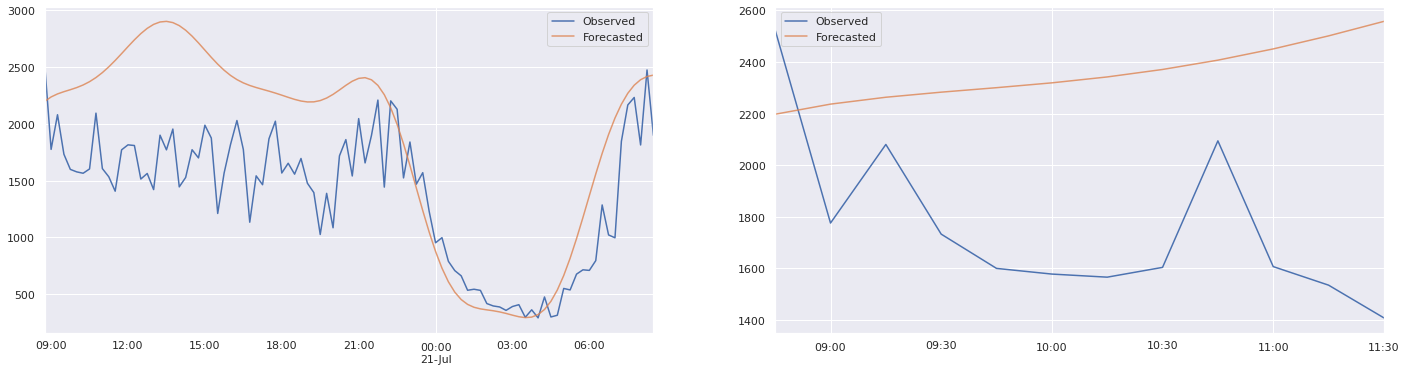

In [220]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
ax[0].set_title("24 Hours")
ax[1].set_title("3 Hour")
showcase_zoom(speculative_remaining_count_through_time[training_split:training_split+day_observations], pd.Series(fm_tbats_res.forecast(day_observations)), ax[0])
showcase_zoom(speculative_remaining_count_through_time[training_split:training_split+forecast_observations], pd.Series(fm_tbats_res.forecast(forecast_observations)), ax[1])

Text(0.5, 1.0, '"Live" - 180 Minutes ahead forecasts as new observations are added.')

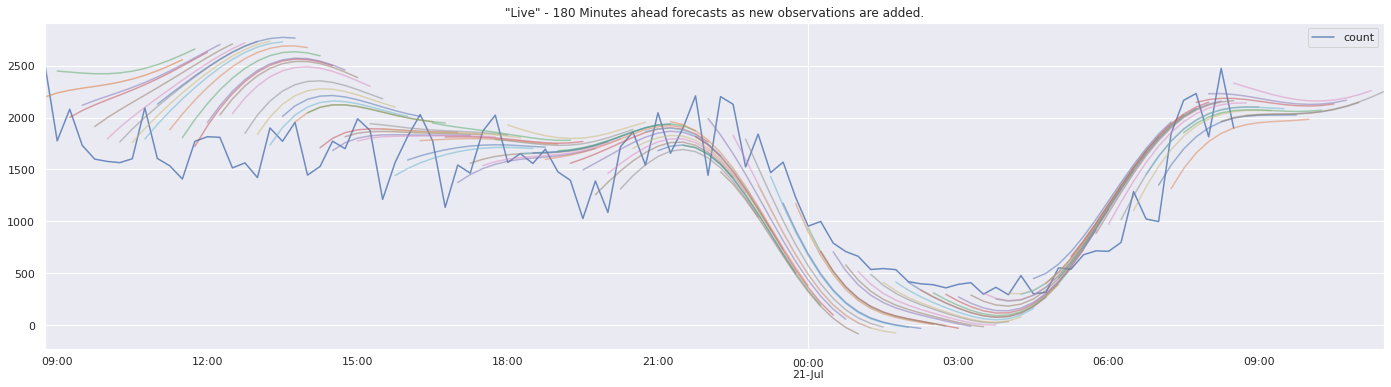

In [221]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
speculative_remaining_count_through_time[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

vis_tbats = copy.deepcopy(fm_tbats_res)

pd.Series(vis_tbats.forecast(forecast_observations), index=speculative_remaining_count_through_time.index[training_split:training_split+forecast_observations]).plot(ax=ax, alpha=0.6)
for i in range(1, day_observations+1): # 24 hour ahead
    vis_tbats.fit(speculative_remaining_count_through_time[:training_split+i])
    pd.Series(vis_tbats.forecast(forecast_observations), index=speculative_remaining_count_through_time.index[training_split+i:training_split+i+forecast_observations]).plot(ax=ax, alpha=0.5)
ax.set_title(f"\"Live\" - {forecast_minutes} Minutes ahead forecasts as new observations are added.")

In [222]:
_, tbats_forecasts_sm = forecast_n_steps(speculative_remaining_count_through_time, copy.deepcopy(fm_tbats_res), training_split, forecast_observations)

In [223]:
#tbats_forecasts_sm.to_csv('../../data/forecasts/peaks_speculative_tbats_forecasts_15.csv')

In [31]:
tbats_forecasts_sm = pd.read_csv('../../data/forecasts/peaks_speculative_tbats_forecasts_15.csv', index_col=0, parse_dates=True)

### ARIMA with Fourier Terms

In [224]:
from pmdarima.preprocessing import FourierFeaturizer
import pmdarima as pm

In [225]:
resulting_models = []
for d_k in range(1, 12):
        daily_transformation = FourierFeaturizer(m=day_observations, k=d_k)
        _, exog_d = daily_transformation.fit_transform(speculative_remaining_count_through_time[:training_split])
        print(d_k)
        ft_fit = pm.auto_arima(speculative_remaining_count_through_time[:training_split],
                             start_q = 2,
                             max_q = 20,
                             start_p = 2,
                             max_p = 20,
                             D = None,
                             exogenous=exog_d,
                             max_order = 30,
                             seasonal = False,
                             information_criterion = 'aic',
                             stepwise = True, # n_jobs = 16
                             trace = 2,
                             cov_type=None
                            )
        resulting_models.append(ft_fit)

1
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=54464.291, Time=12.42 sec
First viable model found (54464.291)
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=90193.360, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=54809.110, Time=0.71 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=61017.543, Time=2.50 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=54615.205, Time=2.54 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=54521.808, Time=6.43 sec
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=9.49 sec
Near non-invertible roots for order (2, 0, 3)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.992)
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=9.79 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=54629.369, Time=1.61 sec
 ARIMA(1,0

/home/jakub/.conda/envs/bp_thesis_pyr/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,0,1)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/home/jakub/.conda/envs/bp_thesis_pyr/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/home/jakub/.conda/envs/bp_thesis_pyr/lib/python3.7/site-packages/pmdarima/arima/arima.py", line 482, in fit
    self._fit(y, X, **fit_args)
  File "/home/jakub/.conda/envs/bp_thesis_pyr/lib/python3.7/site-packages/pmdarima/arima/arima.py", line 403, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/home/jakub/.conda/envs/bp_thesis_pyr/lib/python3.7/site-packages/pmdarima/arima/arima.py", line 397, in _fit_wrapper
    **fit_args)
  File "/home/jakub/.conda/envs/bp_thesis_pyr/lib/python3.7/site-packages/statsmode

 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=nan sec
Near non-invertible roots for order (3, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=39.68 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=54318.998, Time=29.42 sec
New best model found (54318.998 < 54320.396)
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=54477.596, Time=15.00 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=54316.643, Time=41.79 sec
New best model found (54316.643 < 54318.998)
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=54319.240, Time=42.02 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=54318.674, Time=30.41 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=54317.106, Time=31.05 sec
Near non-invertible roots for order (4, 0, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=42.68 sec
Ne

In [226]:
smallest_aic = min(resulting_models, key=lambda x: x.aic())

In [227]:
smallest_aic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3559
Model:               SARIMAX(2, 0, 4)   Log Likelihood              -27136.020
Date:                Sat, 13 Mar 2021   AIC                          54306.040
Time:                        17:37:30   BIC                          54411.053
Sample:                             0   HQIC                         54343.486
                               - 3559                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
FOURIER_S96-0   979.1138     73.988     13.233      0.000     834.099    1124.128
FOURIER_C96-0  -446.7643    110.017     -4.061      0.000    -662.393    -231.136
FOURIER_S96-1   458.1205     91.075      5.030      0.000     279.616     636.625
FOURIER_C96-1   156.8888     77.316      2.029      0.042       5.352     308.426
FOURIER_S96-2   -75.6527     73.523     -1.029      0.303    -219.756      68.450
FOURIER_C96-2   246.5469     70.177      3.513      0.000     109.003     384.090
FOURIER_S96-3   105.2247     60.327      1.744      0.081     -13.014     223.463
FOURIER_C96-3    -2.4327     56.178     -0.043      0.965    -112.540     107.675
FOURIER_S96-4   112.4746     39.426      2.853      0.004      35.201     189.748
FOURIER_C96-4    57.1193     40.848      1.398      0.162     -22.942     137.181
ar.L1             1.7355      0.016    110.122      0.000       1.705       1.766
ar.L2            -0.7356      0.016    -46.762      0.000      -0.766      -0.705
ma.L1            -1.0825      0.017    -63.049      0.000      -1.116      -1.049
ma.L2             0.1208      0.014      8.449      0.000       0.093       0.149
ma.L3             0.0458      0.014      3.199      0.001       0.018       0.074
ma.L4            -0.0579      0.010     -6.008      0.000      -0.077      -0.039
sigma2         2.453e+05      1.317   1.86e+05      0.000    2.45e+05    2.45e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             76404.33
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             1.42
Prob(H) (two-sided):                  0.14   Kurtosis:                        25.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  1e+20. Standard errors may be unstable.
"""

In [228]:
print(smallest_aic, smallest_aic.aic())

 ARIMA(2,0,4)(0,0,0)[0]           54306.0397424165


In [ ]:
# K = 5

### Selected model

In [32]:
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.api import SARIMAX

In [69]:
fourier_dp = DeterministicProcess(anomaly_free_remaining_speculative.index, period=day_observations, fourier=5)
exog_fourier = fourier_dp.in_sample()

In [70]:
exog_fourier = exog_fourier.append(
                fourier_dp.out_of_sample(forecast_observations,
                                       forecast_index=pd.date_range(
                                               start=exog_fourier.index[-1]+pd.Timedelta(minutes=15),
                                               periods=forecast_observations,
                                               freq=f"{resample_second_interval}S")))

In [71]:
arimax_mod = SARIMAX(speculative_remaining_count_through_time[:training_split], order=(2, 0, 4), exog=exog_fourier[:training_split], trend='c')
arimax_res = arimax_mod.fit()
print(arimax_res.summary())

/home/jakub/.conda/envs/bp_thesis_pyr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
/home/jakub/.conda/envs/bp_thesis_pyr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                 3559
Model:               SARIMAX(2, 0, 4)   Log Likelihood              -27147.210
Date:                Wed, 07 Apr 2021   AIC                          54330.419
Time:                        19:47:05   BIC                          54441.609
Sample:                    06-13-2019   HQIC                         54370.068
                         - 07-20-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    296.7507     88.474      3.354      0.001     123.346     470.156
sin(1,96)   1006.2780    180.188      5.585      0.000     653.117    1359.439
cos(1,96)   -381.6479    190.350     -2.005      0.0

In [ ]:
#joblib.dump(arimax_res, open(f'../../models/arimax_peaks_{minute_interval}_{resample_second_interval}', 'wb'))

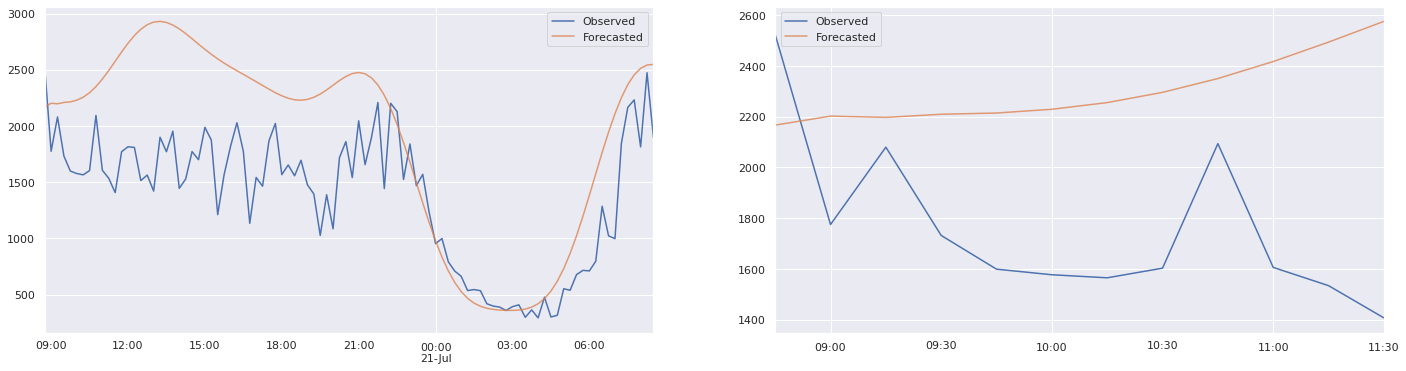

In [233]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)
ax[0].set_title("24 Hours")
ax[1].set_title("3 Hour")
showcase_zoom(speculative_remaining_count_through_time[training_split:training_split+day_observations],
              pd.Series(arimax_res.forecast(
                    day_observations,
                    exog=exog_fourier[training_split:training_split+day_observations])),
              ax[0])
showcase_zoom(speculative_remaining_count_through_time[training_split:training_split+forecast_observations],
              pd.Series(arimax_res.forecast(
                    forecast_observations,
                    exog=exog_fourier[training_split:training_split+forecast_observations])),
              ax[1])

In [72]:
arimax_timestamps = []
arimax_forecasts_sm = []
for step in range(training_split, len(anomaly_free_remaining_speculative)):
    clear_output(wait=True)
    print("Step: ", step + 1, "-", len(anomaly_free_remaining_speculative), "; %:", (step + 1)/len(anomaly_free_remaining_speculative), end='\r')
    data_extended = anomaly_free_remaining_speculative[step:step+1]
    arimax_timestamps.append(data_extended.index[0])
    arimax_res = arimax_res.append(data_extended, exog=exog_fourier[step:step+1])
    forecast_exog = exog_fourier[step:step+forecast_observations]
    arimax_forecasts_sm.append(arimax_res.forecast(min(forecast_observations, len(forecast_exog)), exog=forecast_exog).values)
arimax_forecasts_sm = pd.DataFrame(index=arimax_timestamps, data=arimax_forecasts_sm, columns=[f"step_{x}" for x in range(1, forecast_observations+1)])
del arimax_timestamps

Text(0.5, 1.0, '"Live" - 180 Minutes ahead forecasts as new observations are added.')

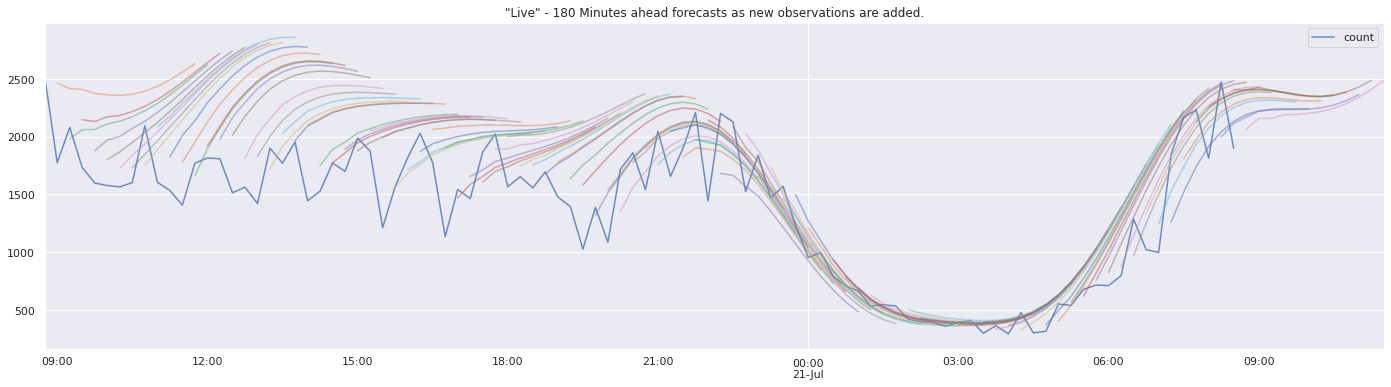

In [235]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)
speculative_remaining_count_through_time[training_split:training_split+day_observations].plot(ax=ax, alpha=0.8)

for forecast in arimax_forecasts_sm[:day_observations].iterrows():
    pd.Series(forecast[1].values,
              index = pd.date_range(
                  start=forecast[0] + pd.Timedelta(minutes=resample_minutes),
                  end=forecast[0] + pd.Timedelta(minutes=forecast_minutes),
                  freq=f"{resample_second_interval}S")
             ).plot(ax=ax, alpha=0.5)
ax.set_title(f"\"Live\" - {forecast_minutes} Minutes ahead forecasts as new observations are added.")

In [73]:
#arimax_forecasts_sm.to_csv('../../data/forecasts/peaks_speculative_arimax_forecasts_15.csv')

In [84]:
arimax_forecasts_sm = pd.read_csv('../../data/forecasts/peaks_speculative_arimax_forecasts_15.csv', index_col=0, parse_dates=True)

# Evaluation - Remaining model

In [194]:
from scipy.stats import norm

### Real-time

In [189]:
arimax_errors = []
for row in arimax_forecasts_fm.iterrows():
    row_timestamp = row[0]
    row_data = row[1]
    # row timestamp is the time when when a forecast was made (time of last observed value), 7:00 -> forecast of 7:15->
    observed_data = remaining_count_through_time.loc[row_timestamp+pd.Timedelta(minutes=15):row_timestamp+pd.Timedelta(minutes=forecast_minutes)]
    arimax_errors.append((observed_data.values.reshape(1, -1)[0] - row_data[:len(observed_data)].values))
arimax_errors = pd.DataFrame(arimax_errors).fillna(0)

In [191]:
arimax_mse, arimax_rmse = rmse_forecasts(arimax_errors)

In [239]:
tbats_errors = []
for row in tbats_forecasts_fm.iterrows():
    row_timestamp = row[0]
    row_data = row[1]
    observed_data = remaining_count_through_time.loc[row_timestamp+pd.Timedelta(minutes=15):row_timestamp+pd.Timedelta(minutes=forecast_minutes)]
    #break
    tbats_errors.append((observed_data.values.reshape(1, -1)[0] - row_data[:len(observed_data)].values))
tbats_errors = pd.DataFrame(tbats_errors).fillna(0)

In [240]:
tbats_mse, tbats_rmse = rmse_forecasts(tbats_errors)

Text(0.5, 1.0, 'TBATS residua distribution')

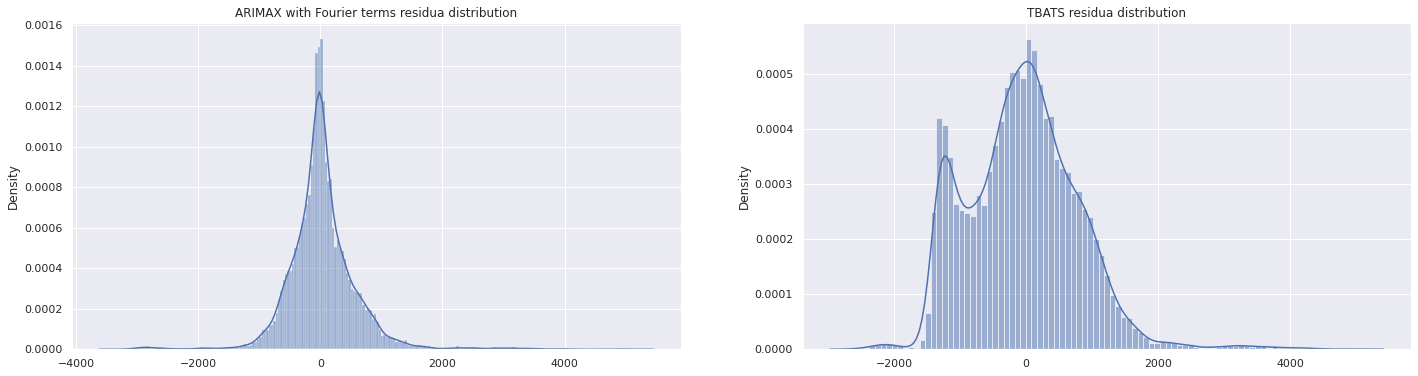

In [195]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)

arimax_residues = pd.Series(arimax_errors.values.flatten())
tbats_residues = pd.Series(tbats_errors.values.flatten())

sns.histplot(arimax_residues, ax=ax[0], stat='density', kde=True)
ax[0].set_title("ARIMAX with Fourier terms residua distribution")
sns.histplot(tbats_residues, ax=ax[1], stat='density', kde=True)
ax[1].set_title("TBATS residua distribution")

In [196]:
tbats_rmse.index = remaining_count_through_time[-len(tbats_mse):].index
arimax_rmse.index = remaining_count_through_time[-len(arimax_mse):].index

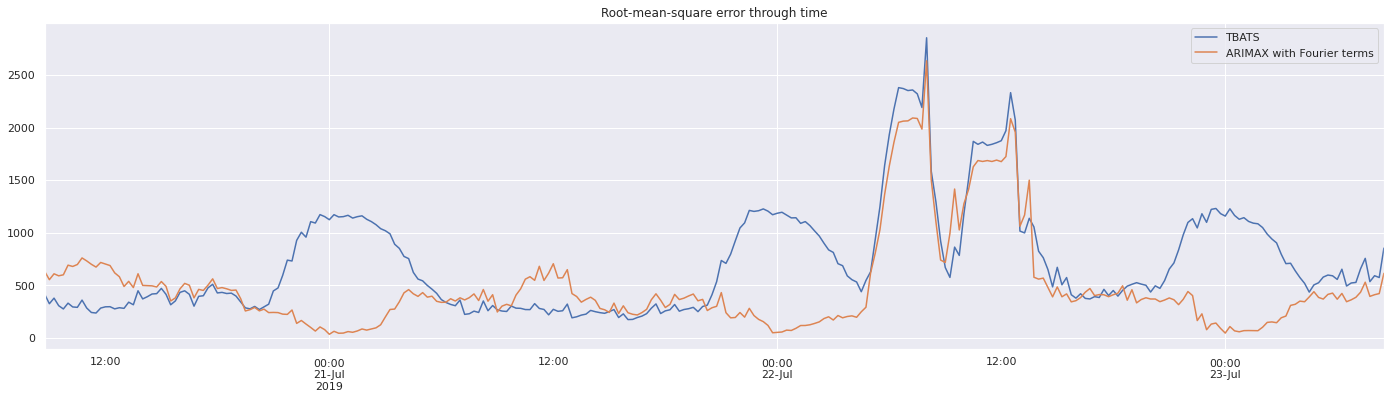

In [197]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)

tbats_rmse[:day_observations*3].plot(ax=ax)
arimax_rmse[:day_observations*3].plot(ax=ax)
ax.set_title("Root-mean-square error through time")
ax.legend(['TBATS', 'ARIMAX with Fourier terms'])

In [205]:
results = pd.DataFrame(
            data=np.array([
                tbats_rmse.sum(),
                arimax_rmse.sum(),
                tbats_mse.sum(),
                arimax_mse.sum()])
                .reshape(1, -1),
            columns = ['tbats_rmse','arimax_rmse','tbats_mse','arimax_mse'])

In [206]:
results

tbats_rmse    arimax_rmse     tbats_mse    arimax_mse
0  1.145238e+06  698911.341435  1.102941e+09  5.131382e+08

In [207]:
for col in results:
    print(col, '{0:.10f}'.format(results[col][0]))

tbats_rmse 1145238.3283065371
arimax_rmse 698911.3414350762
tbats_mse 1102941131.8011631966
arimax_mse 513138159.9586991072


In [22]:
len(remaining_count_through_time[training_split:])

1525

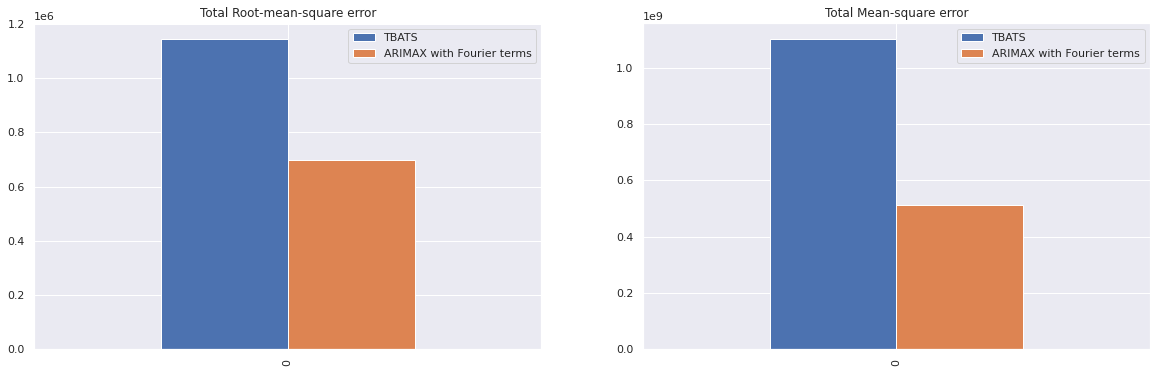

In [200]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 6)

results[['tbats_rmse', 'arimax_rmse']].plot(kind='bar', ax=ax[0])
ax[0].set_title("Total Root-mean-square error")
ax[0].legend(["TBATS", "ARIMAX with Fourier terms"])
results[['tbats_mse', 'arimax_mse']].plot(kind='bar', ax=ax[1])
ax[1].set_title("Total Mean-square error")
ax[1].legend(["TBATS", "ARIMAX with Fourier terms"])

### Speculative

In [237]:
arimax_errors = []
for row in arimax_forecasts_sm.iterrows():
    row_timestamp = row[0]
    row_data = row[1]
    observed_data = speculative_remaining_count_through_time.loc[row_timestamp+pd.Timedelta(minutes=15):row_timestamp+pd.Timedelta(minutes=forecast_minutes)]
    #break
    arimax_errors.append((observed_data.values.reshape(1, -1)[0] - row_data[:len(observed_data)].values))
arimax_errors = pd.DataFrame(arimax_errors).fillna(0)

In [238]:
arimax_mse, arimax_rmse = rmse_forecasts(arimax_errors)

In [241]:
tbats_errors = []
for row in tbats_forecasts_sm.iterrows():
    row_timestamp = row[0]
    row_data = row[1]
    observed_data = speculative_remaining_count_through_time.loc[row_timestamp+pd.Timedelta(minutes=15):row_timestamp+pd.Timedelta(minutes=forecast_minutes)]
    #break
    tbats_errors.append((observed_data.values.reshape(1, -1)[0] - row_data[:len(observed_data)].values))
tbats_errors = pd.DataFrame(tbats_errors).fillna(0)

In [242]:
tbats_mse, tbats_rmse = rmse_forecasts(tbats_errors)

Text(0.5, 1.0, 'TBATS residua distribution')

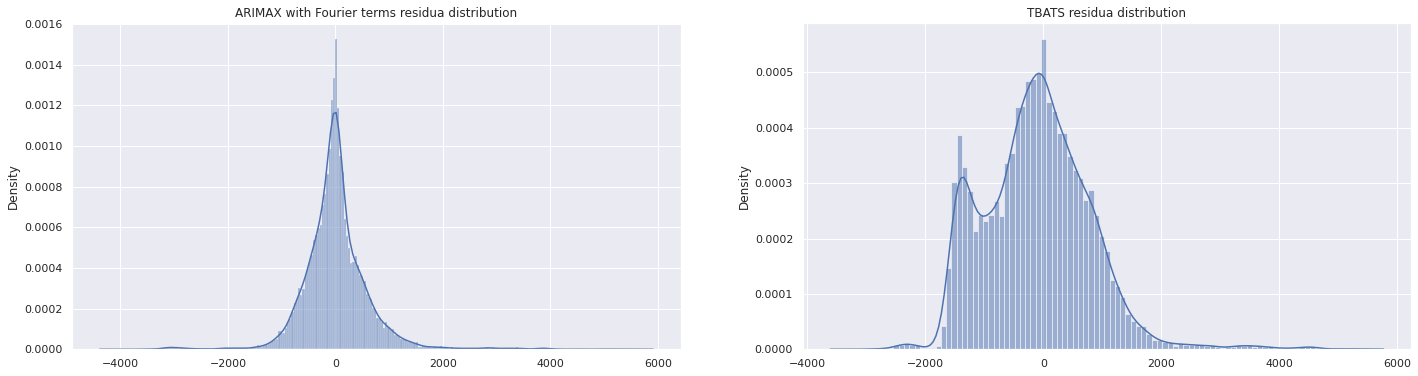

In [244]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)

arimax_residues = pd.Series(arimax_errors.values.flatten())
tbats_residues = pd.Series(tbats_errors.values.flatten())

sns.histplot(arimax_residues, ax=ax[0], stat='density', kde=True)
ax[0].set_title("ARIMAX with Fourier terms residua distribution")
sns.histplot(tbats_residues, ax=ax[1], stat='density', kde=True)
ax[1].set_title("TBATS residua distribution")

In [245]:
tbats_rmse.index = speculative_remaining_count_through_time[-len(tbats_mse):].index
arimax_rmse.index = speculative_remaining_count_through_time[-len(arimax_mse):].index

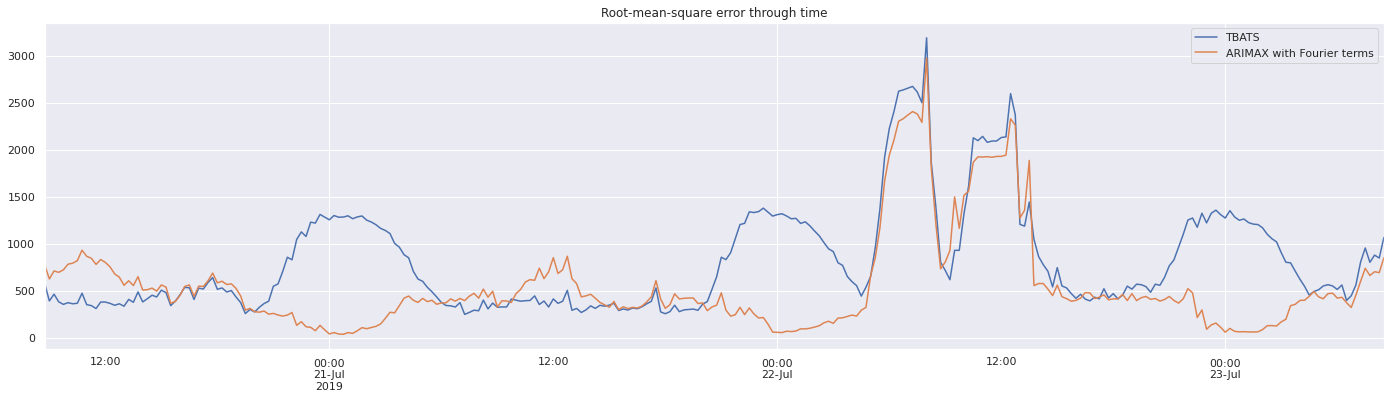

In [246]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)

tbats_rmse[:day_observations*3].plot(ax=ax)
arimax_rmse[:day_observations*3].plot(ax=ax)
ax.set_title("Root-mean-square error through time")
ax.legend(['TBATS', 'ARIMAX with Fourier terms'])

In [247]:
results = pd.DataFrame(
            data=np.array([
                tbats_rmse.sum(),
                arimax_rmse.sum(),
                tbats_mse.sum(),
                arimax_mse.sum()])
                .reshape(1, -1),
            columns = ['tbats_rmse','arimax_rmse','tbats_mse','arimax_mse'])

In [248]:
results

tbats_rmse    arimax_rmse     tbats_mse    arimax_mse
0  1.230700e+06  756247.278205  1.285935e+09  6.086771e+08

In [249]:
for col in results:
    print(col, '{0:.10f}'.format(results[col][0]))

tbats_rmse 1230699.7950333261
arimax_rmse 756247.2782052688
tbats_mse 1285935083.1669168472
arimax_mse 608677095.0763866901


In [23]:
len(speculative_remaining_count_through_time[training_split:])

1525

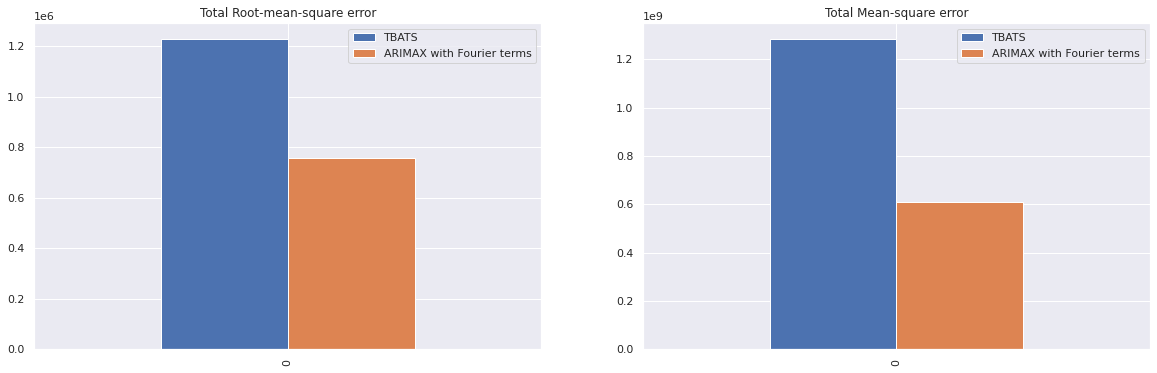

In [250]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 6)

results[['tbats_rmse', 'arimax_rmse']].plot(kind='bar', ax=ax[0])
ax[0].set_title("Total Root-mean-square error")
ax[0].legend(["TBATS", "ARIMAX with Fourier terms"])
results[['tbats_mse', 'arimax_mse']].plot(kind='bar', ax=ax[1])
ax[1].set_title("Total Mean-square error")
ax[1].legend(["TBATS", "ARIMAX with Fourier terms"])

# Forecasting temporar largest peaks #

In [43]:
def preprocess_rf_regression(data, n_back=12, n_steps=12):
    data = data.resample(f"{resample_second_interval}S").sum().fillna(0)
    # Time is set to t0
    data.index = pd.date_range(start=(data.index[0] - pd.Timedelta(minutes=forecast_minutes)),
                               periods=len(data), freq=f"{resample_second_interval}S")
    
    data[f't+{n_steps}'] = data['count']
    for w in range(n_steps-1, 0, -1):
        data[f't+{w}'] = data[f't+{w+1}'].shift(1)
    data[f't-0'] = data[f't+{1}'].shift(1)
    for w in range(-1, -n_back, -1):
        data[f't-{abs(w)}'] = data[f't-{abs(w+1)}'].shift(1)
    return data.fillna(0)

In [70]:
def temporar_forecast_plot(series, model, max_len=30, ax=None):
    series_data = peak_data.loc[series]
    
    processed_data = preprocess_rf_regression(series_data)
    processed_x = processed_data.filter(regex=("t[-].*")).values
    
    if(ax==None):
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(24, 6)
    series_data[:max_len+20]['count'].plot(ax=ax)
        
    for i in range(10, min(max_len, len(processed_data))):
        index = pd.date_range(start=processed_data.index[i],
                              end=(processed_data.index[i] + pd.Timedelta(minutes=forecast_minutes)), freq=f'{resample_second_interval}S')
        flipped_data = np.flip(processed_x[i])
        
        yhat = model.predict(flipped_data.reshape(1, -1))
        pd.Series(np.insert(yhat[0], 0, flipped_data[-1]), index=index).plot(ax=ax, alpha=0.4)

In [65]:
training_peaks = []
#for col in speculative_tracked_through_time:
#    if(col != 's-count' and col != 'l-count'):
#        training_peaks.extend(speculative_tracked_through_time[col].loc[:training_timespan[-1]].dropna())
        
for col in largest_peaks_through_time:
    if(col != 'count'):
        training_peaks.extend(largest_peaks_through_time[col].loc[:training_timespan[-1]].dropna())
training_peaks = pd.Series(training_peaks).unique()

In [60]:
peaks_by_size = pd.read_csv("../../data/peaks/peaks_by_size_extended.csv")

In [63]:
testing_peaks = []
for col in speculative_tracked_through_time:
    if(col != 's-count' and col != 'l-count'):
        testing_peaks.extend(speculative_tracked_through_time[col].loc[:training_timespan[-1]:].dropna())
        
for col in largest_peaks_through_time:
    if(col != 'count'):
        testing_peaks.extend(largest_peaks_through_time[col].loc[training_timespan[-1]:].dropna())
testing_peaks = pd.Series(testing_peaks).unique()

In [66]:
unobserved_series = []
for series in testing_peaks:
    if (series not in training_peaks):
        unobserved_series.append(series)

In [67]:
testing_peaks = np.array(unobserved_series)

In [68]:
out_of_sample_peaks_by_size = peaks_by_size.loc[peaks_by_size['hash'].isin(testing_peaks)]['hash']

In [100]:
training_x = []
training_y = []

for series in training_peaks:
    sample_data = preprocess_rf_regression(peak_data.loc[series])
    
    filtered_data_x = []
    filtered_data_y = []
    
    sample_data_y = sample_data[:1*day_observations].filter(regex=("t[+].*")).values
    sample_data_x = sample_data[:1*day_observations].filter(regex=("t[-].*")).values
    
    

    for i, row in enumerate(sample_data_x):
        if (row.sum() <= 2000):
            continue
        else:
            filtered_data_x.append(np.flip(row))
            filtered_data_y.append(np.flip(sample_data_y[i]))
    
    
    training_y.extend(filtered_data_y)
    training_x.extend(filtered_data_x)
    
training_x = np.array(training_x)
training_y = np.array(training_y)

In [25]:
len(training_x)

12116

## Random Forest Regression

In [32]:
from sklearn.ensemble import RandomForestRegressor

In [33]:
rfg_mod = RandomForestRegressor(n_estimators=50, n_jobs=1)
rfg_mod.fit(training_x, training_y)

RandomForestRegressor(n_estimators=50, n_jobs=1)

In [47]:
#rfg_mod = joblib.load(f'../../models/random_forest_regression_peaks_{minute_interval}_{resample_second_interval}', 'r')

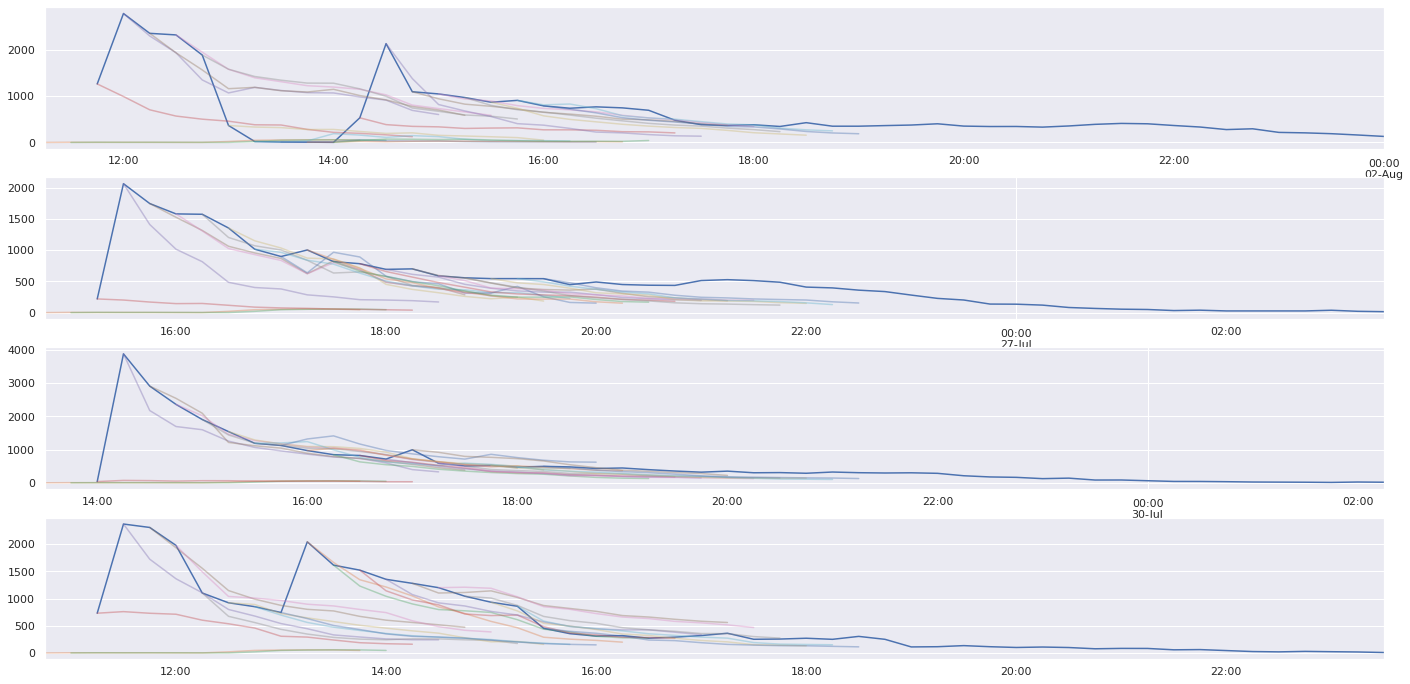

In [71]:
n_figs = 4
fig, ax = plt.subplots(n_figs, 1)
fig.set_size_inches(24, n_figs*3)

for i in range(1, n_figs+1):
    temporar_forecast_plot(out_of_sample_peaks_by_size.iloc[-1+i], rfg_mod, ax=ax[i-1])

In [87]:
#joblib.dump(rfg_mod, open(f'../../models/random_forest_regression_peaks_{minute_interval}_{resample_second_interval}', 'wb'))

## Gradient Boosting Regressor

In [103]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import RegressorChain

In [104]:
gbr_mod = RegressorChain(GradientBoostingRegressor(random_state=0))
gbr_mod.fit(training_x, training_y)

RegressorChain(base_estimator=GradientBoostingRegressor(random_state=0))

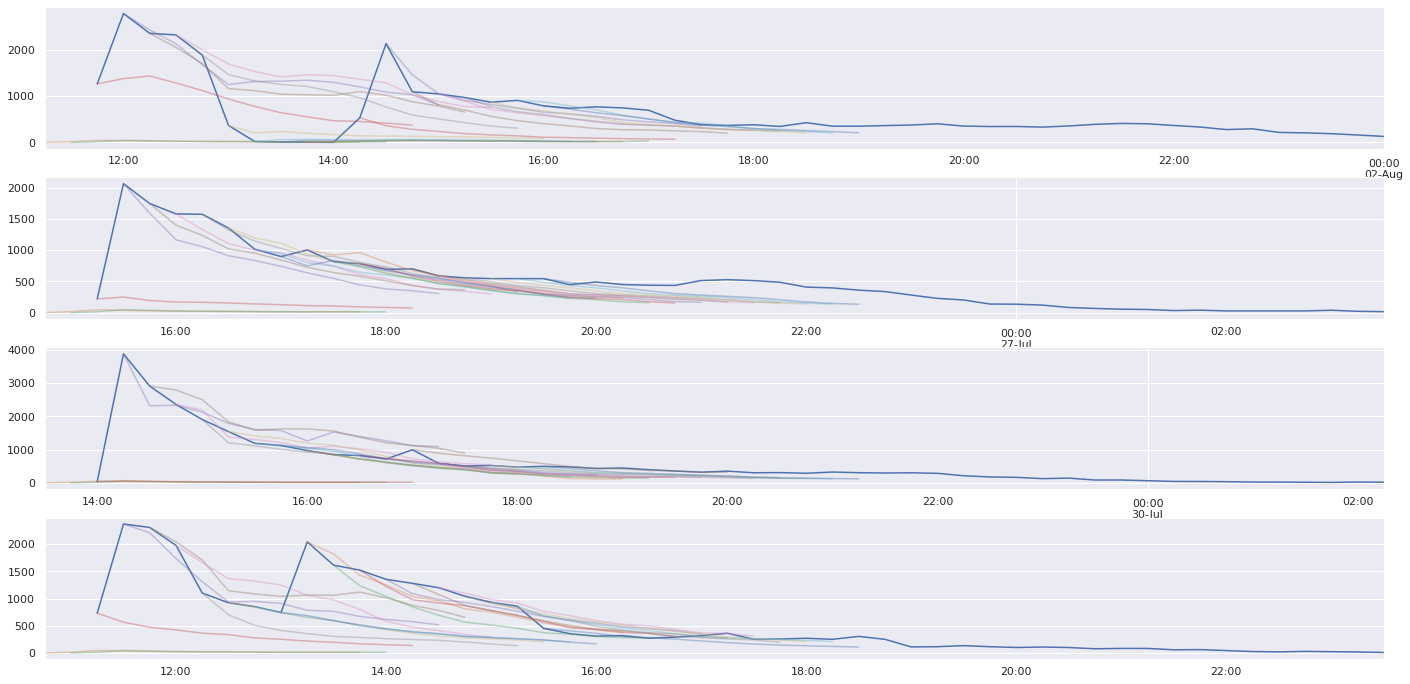

In [105]:
n_figs = 4
fig, ax = plt.subplots(n_figs, 1)
fig.set_size_inches(24, n_figs*3)

for i in range(1, n_figs+1):
    temporar_forecast_plot(out_of_sample_peaks_by_size.iloc[-1+i], gbr_mod, ax=ax[i-1])

## Ada Boost Regressor

In [106]:
from sklearn.ensemble import AdaBoostRegressor

In [107]:
adbr_mod = RegressorChain(AdaBoostRegressor(random_state=0, n_estimators=50))
adbr_mod.fit(training_x, training_y)

RegressorChain(base_estimator=AdaBoostRegressor(random_state=0))

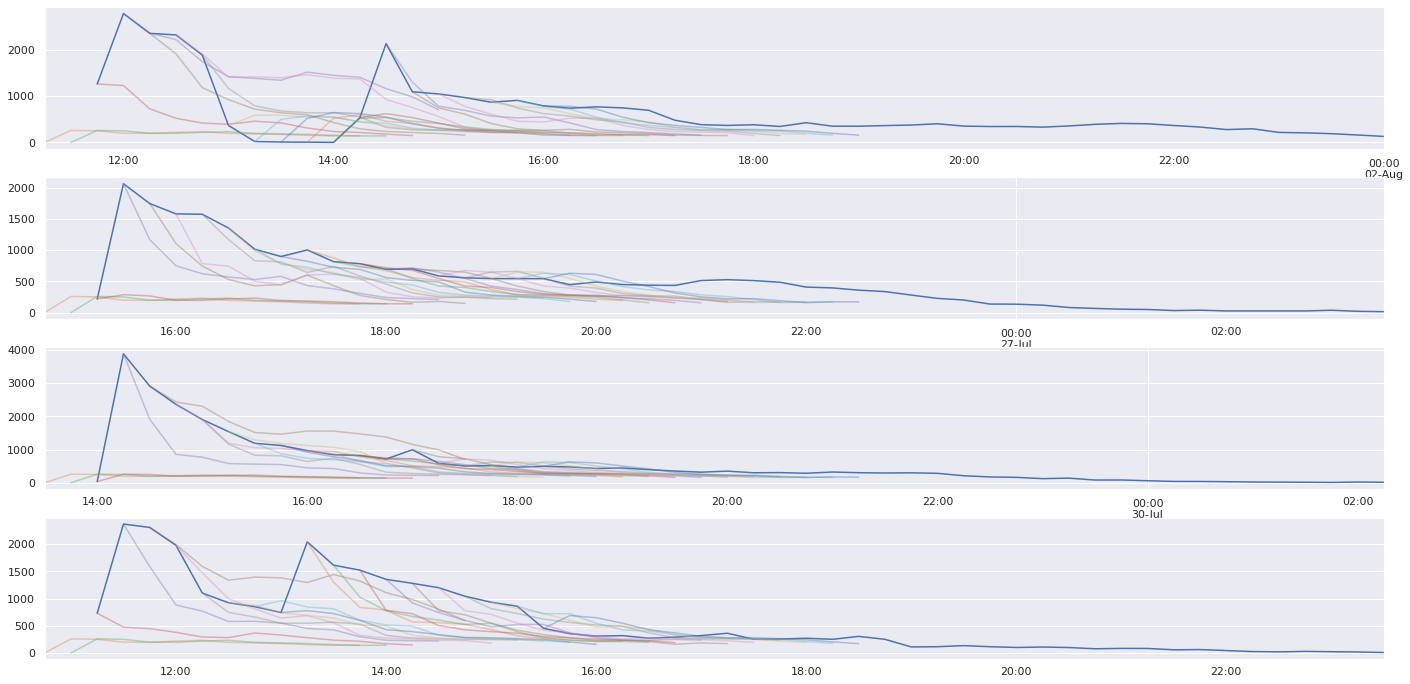

In [108]:
n_figs = 4
fig, ax = plt.subplots(n_figs, 1)
fig.set_size_inches(24, n_figs*3)

for i in range(1, n_figs+1):
    temporar_forecast_plot(out_of_sample_peaks_by_size.iloc[-1+i], adbr_mod, ax=ax[i-1])

## Linear regression

In [98]:
from sklearn import linear_model

In [101]:
linr_mod = linear_model.LinearRegression()
linr_mod.fit(training_x, training_y)

LinearRegression()

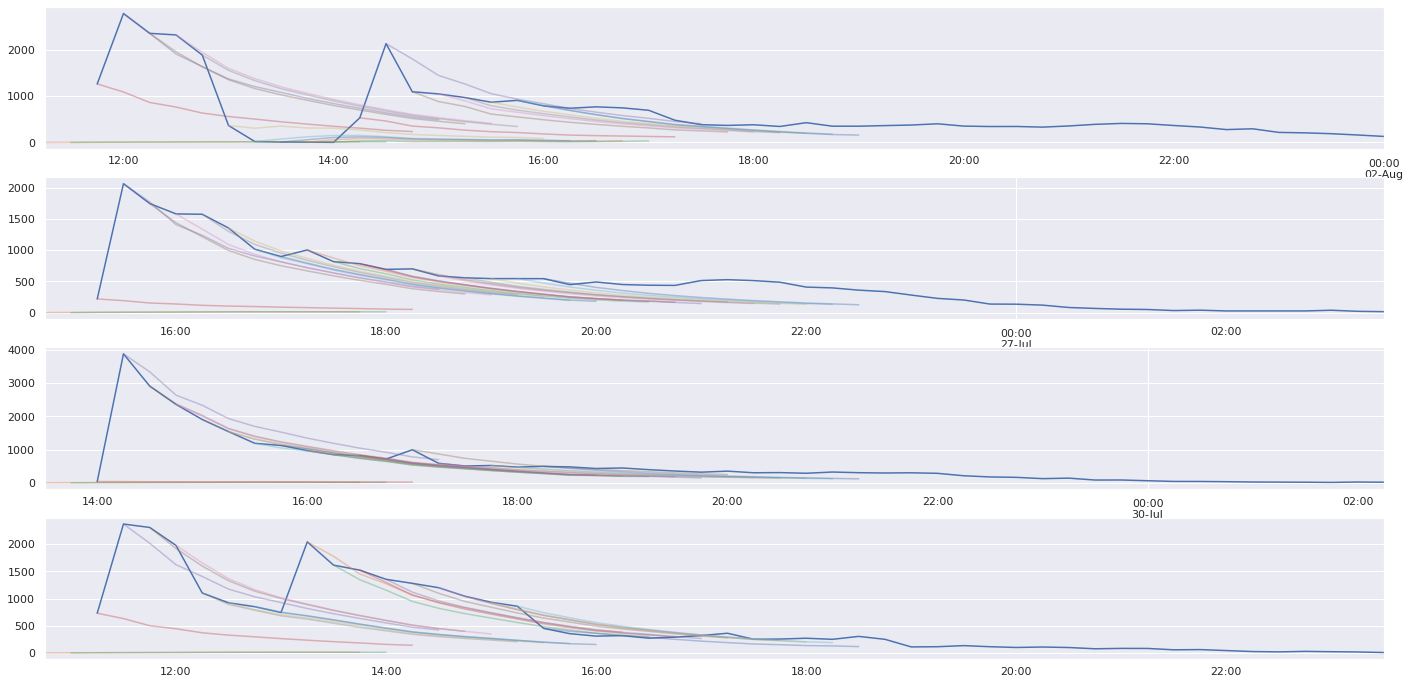

In [102]:
n_figs = 4
fig, ax = plt.subplots(n_figs, 1)
fig.set_size_inches(24, n_figs*3)

for i in range(1, n_figs+1):
    temporar_forecast_plot(out_of_sample_peaks_by_size.iloc[-1+i], linr_mod, ax=ax[i-1])

## KNR

In [109]:
from sklearn.neighbors import KNeighborsRegressor

In [110]:
knr_mod = KNeighborsRegressor(n_neighbors=5)
knr_mod.fit(training_x, training_y)

KNeighborsRegressor()

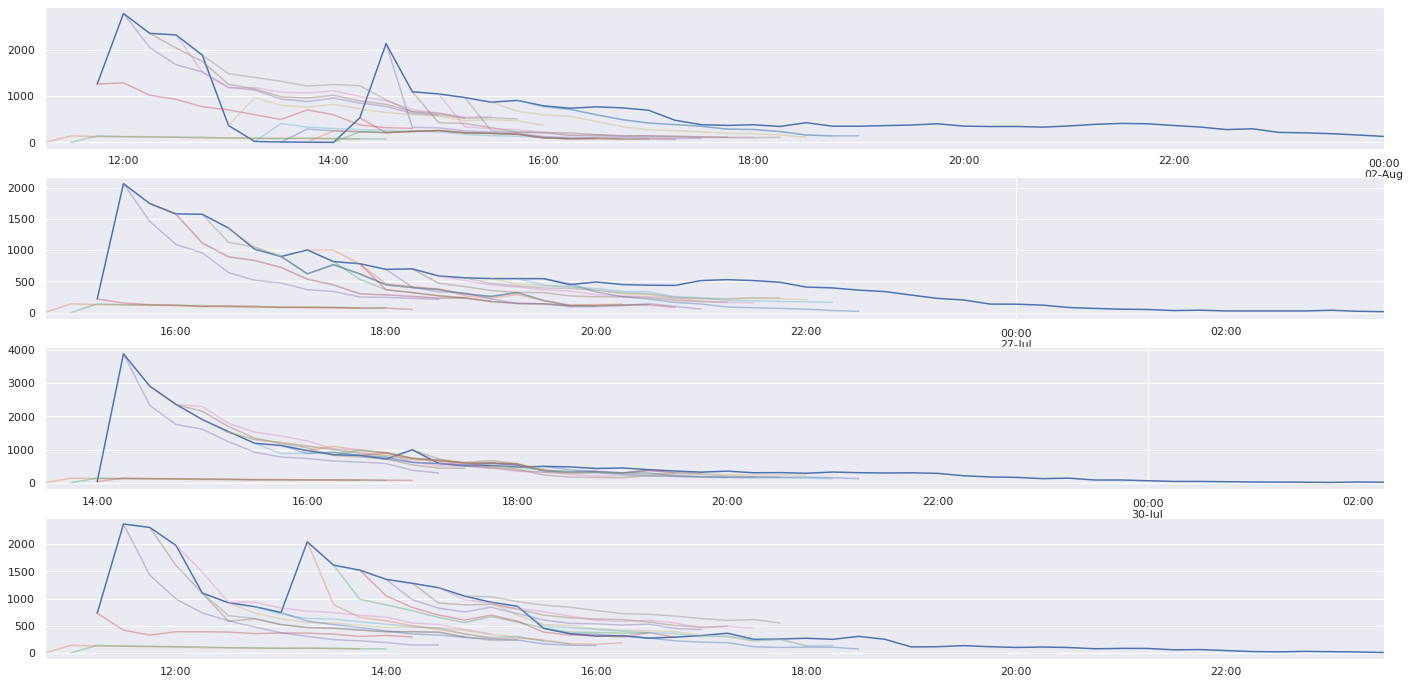

In [111]:
n_figs = 4
fig, ax = plt.subplots(n_figs, 1)
fig.set_size_inches(24, n_figs*3)

for i in range(1, n_figs+1):
    temporar_forecast_plot(out_of_sample_peaks_by_size.iloc[-1+i], knr_mod, ax=ax[i-1])

# Evaluation

In [112]:
from sklearn.metrics import mean_squared_error

In [113]:
def predict_all(model, testing_data):
    forecast = []
    print(model)
    for step, row in enumerate(testing_data):
        clear_output(wait=True)
        print("Step: ", step + 1, "-", len(testing_data), "; %:", (step)/len(testing_data), end='\r')
        forecast.append(model.predict(row.reshape(1, -1))[0])
    return np.array(forecast)

In [114]:
testing_x = []
testing_y = []
for series in testing_peaks:
    sample_data = preprocess_rf_regression(peak_data.loc[series], n_back=12)
    sample_data_y = sample_data[:1*day_observations].filter(regex=("t[+].*")).values
    sample_data_x = sample_data[:1*day_observations].filter(regex=("t[-].*")).values
    testing_y.extend(sample_data_y)
    testing_x.extend(sample_data_x)
testing_x = np.flip(np.array(testing_x), axis=1)
testing_y = np.flip(np.array(testing_y), axis=1)

In [ ]:
rfg_mse = mean_squared_error(testing_y, predict_all(rfg_mod, testing_x))
gbr_mse = mean_squared_error(testing_y, predict_all(gbr_mod, testing_x))
adbr_mse = mean_squared_error(testing_y, predict_all(adbr_mod, testing_x))
#br_mse = mean_squared_error(testing_y, predict_all(br_mod, testing_x))
linr_mse = mean_squared_error(testing_y, predict_all(linr_mod, testing_x))
knr_mse = mean_squared_error(testing_y, predict_all(knr_mod, testing_x))

In [ ]:
rfg_rmse = np.sqrt(rfg_mse)
gbr_rmse = np.sqrt(gbr_mse)
adbr_rmse = np.sqrt(adbr_mse)
#br_rmse = np.sqrt(br_mse)
linr_rmse = np.sqrt(linr_mse)
knr_rmse = np.sqrt(knr_mse)

In [ ]:
regression_results = pd.DataFrame([[rfg_mse, rfg_rmse,
                                   gbr_mse, gbr_rmse,
                                   adbr_mse, adbr_rmse,
                                   #br_mse, br_rmse,
                                   linr_mse, linr_rmse,
                                   knr_mse, knr_rmse]],
                                  columns=['rfg_mse', 'rfg_rmse',
                                   'gbr_mse', 'gbr_rmse',
                                   'adbr_mse', 'adbr_rmse',
                                   #'br_mse', 'br_rmse',
                                   'linr_mse', 'linr_rmse',
                                   'knr_mse', 'knr_rmse'])

In [75]:
regression_results

rfg_mse    rfg_rmse       gbr_mse    gbr_rmse      adbr_mse  \
0  10304.078805  101.509008  10779.911582  103.826353  34748.196292   

    adbr_rmse      linr_mse   linr_rmse       knr_mse    knr_rmse  
0  186.408681  10739.096918  103.629614  15474.726015  124.397452

Text(0.5, 1.0, 'Regression models RMSE')

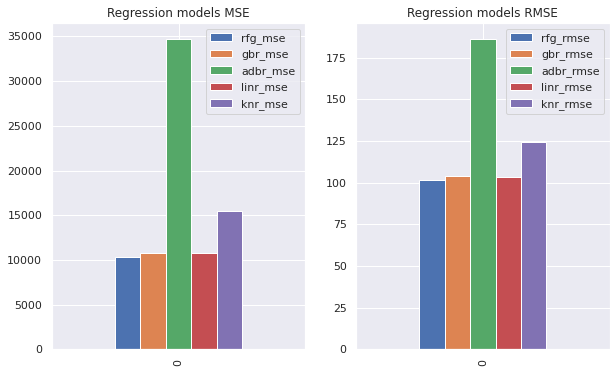

In [76]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 6)

regression_results[['rfg_mse', 'gbr_mse', 'adbr_mse', 'linr_mse', 'knr_mse']].plot(kind='bar', ax=ax[0])
ax[0].set_title("Regression models MSE")
#ax.legend(["Real-time", "Speculative"])

regression_results[['rfg_rmse', 'gbr_rmse', 'adbr_rmse', 'linr_rmse', 'knr_rmse']].plot(kind='bar', ax=ax[1])
ax[1].set_title("Regression models RMSE")

In [44]:
detected_peaks = pd.read_csv("../../data/peaks/detected_peaks.csv")
detected_peaks['peak_time'] = pd.to_datetime(detected_peaks['peak_time'])

In [45]:
testing_x_peaks = []
testing_y_peaks = []
for index, series in detected_peaks[detected_peaks['hash'].isin(testing_peaks)].iterrows():
    sample_data = preprocess_rf_regression(peak_data.loc[series['hash']])
    sample_data_y = sample_data[:series['peak_time']+pd.Timedelta(hours=3)].filter(regex=("t[+].*")).values
    sample_data_x = sample_data[:series['peak_time']+pd.Timedelta(hours=3)].filter(regex=("t[-].*")).values
    testing_y_peaks.extend(sample_data_y)
    testing_x_peaks.extend(sample_data_x)
testing_x_peaks = np.flip(np.array(testing_x_peaks), axis=1)
testing_y_peaks = np.flip(np.array(testing_y_peaks), axis=1)

In [49]:
rfg_mse_peak = mean_squared_error(testing_y_peaks, predict_all(rfg_mod, testing_x_peaks))
gbr_mse_peak = mean_squared_error(testing_y_peaks, predict_all(gbr_mod, testing_x_peaks))
adbr_mse_peak = mean_squared_error(testing_y_peaks, predict_all(adbr_mod, testing_x_peaks))
#br_mse_peak = mean_squared_error(testing_y_peaks, predict_all(br_mod, testing_x_peaks))
linr_mse_peak = mean_squared_error(testing_y_peaks, predict_all(linr_mod, testing_x_peaks))
knr_mse_peak = mean_squared_error(testing_y_peaks, predict_all(knr_mod, testing_x_peaks))

In [50]:
rfg_rmse_peak = np.sqrt(rfg_mse_peak)
gbr_rmse_peak = np.sqrt(gbr_mse_peak)
adbr_rmse_peak = np.sqrt(adbr_mse_peak)
#br_rmse_peak = np.sqrt(br_mse_peak)
linr_rmse_peak = np.sqrt(linr_mse_peak)
knr_rmse_peak = np.sqrt(knr_mse_peak)

In [51]:
regression_results_peak = pd.DataFrame([[rfg_mse_peak, rfg_rmse_peak,
                                   gbr_mse_peak, gbr_rmse_peak,
                                   adbr_mse_peak, adbr_rmse_peak,
                                   #br_mse_peak, br_rmse_peak,
                                   linr_mse_peak, linr_rmse_peak,
                                   knr_mse_peak, knr_rmse_peak]],
                                  columns=['rfg_mse_peak', 'rfg_rmse_peak',
                                   'gbr_mse_peak', 'gbr_rmse_peak',
                                   'adbr_mse_peak', 'adbr_rmse_peak',
                                   #'br_mse_peak', 'br_rmse_peak',
                                   'linr_mse_peak', 'linr_rmse_peak',
                                   'knr_mse_peak', 'knr_rmse_peak'])

In [52]:
regression_results_peak

rfg_mse_peak  rfg_rmse_peak  gbr_mse_peak  gbr_rmse_peak  adbr_mse_peak  \
0  66316.609617     257.520115  67969.877871     260.710333   71372.639023   

   adbr_rmse_peak  linr_mse_peak  linr_rmse_peak  knr_mse_peak  knr_rmse_peak  
0      267.156581   67938.969518      260.651049   65205.42883     255.353537

Text(0.5, 1.0, 'Regression models Peak RMSE')

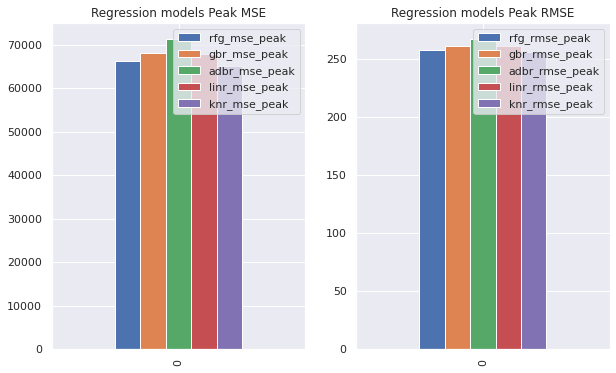

In [53]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 6)

regression_results_peak[['rfg_mse_peak', 'gbr_mse_peak', 'adbr_mse_peak',
                         'linr_mse_peak', 'knr_mse_peak']].plot(kind='bar', ax=ax[0])
ax[0].set_title("Regression models Peak MSE")
#ax[0].set_yscale("log")
#ax.legend(["Real-time", "Speculative"])

regression_results_peak[['rfg_rmse_peak', 'gbr_rmse_peak', 'adbr_rmse_peak',
                         'linr_rmse_peak', 'knr_rmse_peak']].plot(kind='bar', ax=ax[1])
ax[1].set_title("Regression models Peak RMSE")

## Random Forest

In [116]:
rfg_forecasts = []
for step in total_timespan[training_split:]:
    clear_output(wait=True)
    print(f"Step: {step}",end='\r')
    
    total_forecast = np.zeros(forecast_observations)
    step_series = largest_peaks_through_time.loc[step].values[:-1]
    for series in step_series:
        if series is not np.nan:
            series_values = preprocess_rf_regression(peak_data.loc[series])
            if step not in series_values.index:
                continue
            series_values_x = series_values.loc[step].filter(regex=("t[-].*")).values            
            series_data = np.flip(series_values_x)
            forecast = rfg_mod.predict(series_data.reshape(1, -1))
            total_forecast = total_forecast + forecast
    rfg_forecasts.append(total_forecast)

In [117]:
rfg_forecasts = np.array(rfg_forecasts,  dtype=object)
rfg_forecasts = pd.DataFrame(np.vstack(rfg_forecasts), index = total_timespan[training_split:])

In [118]:
#rfg_forecasts.to_csv('../../data/forecasts/peaks_largest_rfg_15.csv')

In [120]:
rfg_forecasts = pd.read_csv('../../data/forecasts/peaks_largest_rfg_15.csv', index_col=0, parse_dates=True)

In [122]:
rfg_forecasts_speculative = []

tracked_mask = np.ones(12, dtype=bool)
tracked_mask[5] = False
tracked_mask[-1] = False

for step in total_timespan[training_split:]:
    clear_output(wait=True)
    print(f"Step: {step}",end='\r')
    
    total_forecast = np.zeros(forecast_observations)
    step_series = speculative_tracked_through_time.loc[step].values[tracked_mask]#[:-1]

    for series in step_series:
        if series is not np.nan:
            series_values = preprocess_rf_regression(peak_data.loc[series])
            if step not in series_values.index:
                continue
            series_values_x = series_values.loc[step].filter(regex=("t[-].*")).values    
            series_data = np.flip(series_values_x)
            forecast = rfg_mod.predict(series_data.reshape(1, -1))
            total_forecast = total_forecast + forecast
    rfg_forecasts_speculative.append(total_forecast)

In [123]:
rfg_forecasts_speculative = np.array(rfg_forecasts_speculative,  dtype=object)
rfg_forecasts_speculative = pd.DataFrame(np.vstack(rfg_forecasts_speculative), index = total_timespan[training_split:])

In [124]:
#rfg_forecasts_speculative.to_csv('../../data/forecasts/peaks_largest_rfg_speculative_15.csv')

In [94]:
rfg_forecasts_speculative = pd.read_csv('../../data/forecasts/peaks_largest_rfg_speculative_15.csv', index_col=0, parse_dates=True)

In [126]:
rfg_errors = []
for row in rfg_forecasts.iterrows():
    row_timestamp = row[0]
    row_data = row[1]
    observed_data = largest_peaks_through_time['count'].loc[row_timestamp+pd.Timedelta(minutes=15):row_timestamp+pd.Timedelta(minutes=forecast_minutes)]
    rfg_errors.append((observed_data.values.reshape(1, -1)[0] - row_data[:len(observed_data)].values))
rfg_errors = pd.DataFrame(rfg_errors).fillna(0)

In [127]:
speculative_total = speculative_tracked_through_time['s-count'] + speculative_tracked_through_time['l-count'] 

In [128]:
rfg_speculative_errors = []
for row in rfg_forecasts_speculative.iterrows():
    row_timestamp = row[0]
    row_data = row[1]
    observed_data = speculative_total.loc[row_timestamp+pd.Timedelta(minutes=15):row_timestamp+pd.Timedelta(minutes=forecast_minutes)]
    rfg_speculative_errors.append((observed_data.values.reshape(1, -1)[0] - row_data[:len(observed_data)].values))
rfg_speculative_errors = pd.DataFrame(rfg_speculative_errors).fillna(0)

Text(0.5, 1.0, 'RFG Speculative residua distribution')

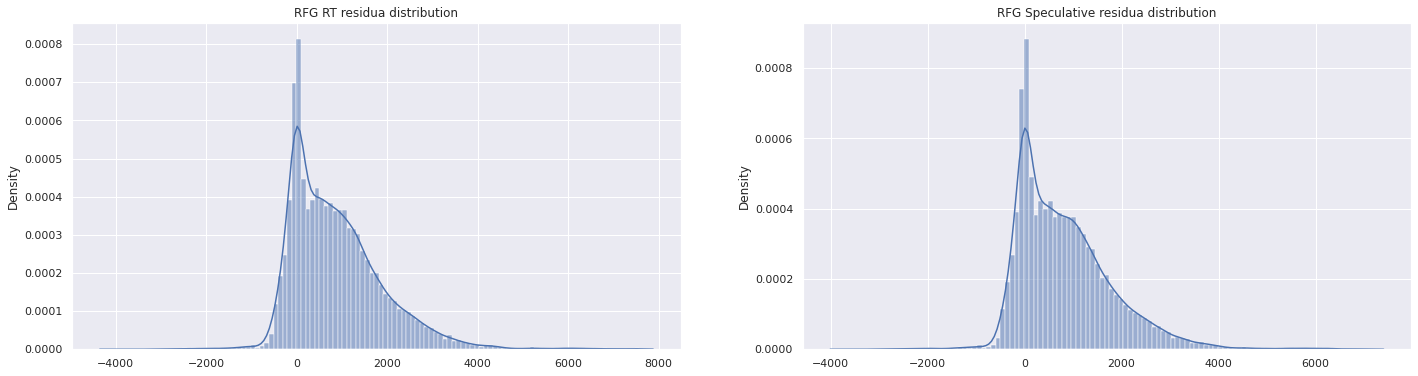

In [129]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 6)

rfg_residues = pd.Series(rfg_errors.values.flatten())
rfg_speculative_residues = pd.Series(rfg_speculative_errors.values.flatten())

sns.histplot(rfg_residues, ax=ax[0], stat='density', kde=True)
ax[0].set_title("RFG RT residua distribution")

sns.histplot(rfg_speculative_residues, ax=ax[1], stat='density', kde=True)
ax[1].set_title("RFG Speculative residua distribution")

In [130]:
rfg_mse, rfg_rmse = rmse_forecasts(rfg_errors)
rfg_speculative_mse, rfg_speculative_rmse = rmse_forecasts(rfg_speculative_errors)

In [131]:
results = pd.DataFrame(
            data=np.array([
                rfg_rmse.sum(),
                rfg_speculative_rmse.sum(),
                ])
                .reshape(1, -1),
            columns = ['rfg_rt_rmse','rfg_speculative_rmse'])

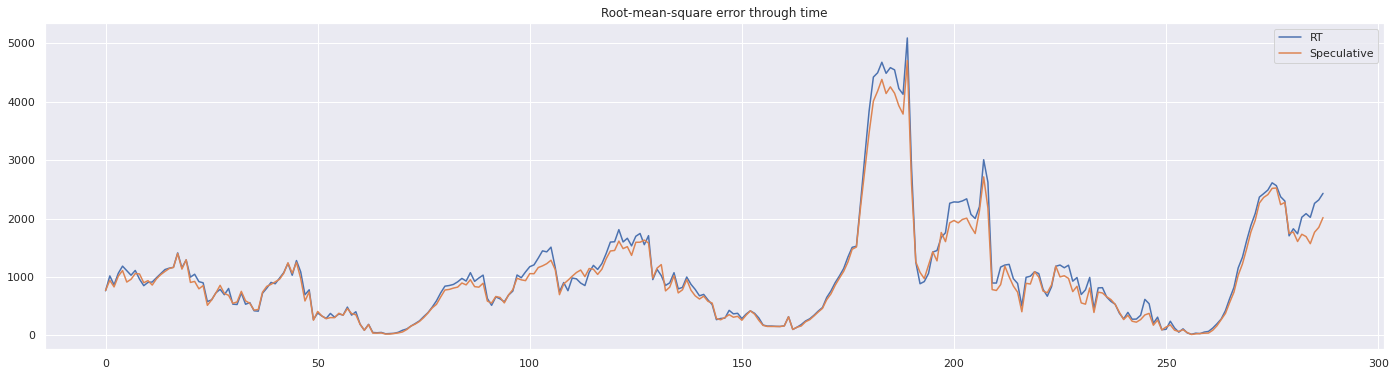

In [132]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(24, 6)

rfg_rmse[:day_observations*3].plot(ax=ax)
rfg_speculative_rmse[:day_observations*3].plot(ax=ax)
ax.set_title("Root-mean-square error through time")
ax.legend(['RT', 'Speculative'])

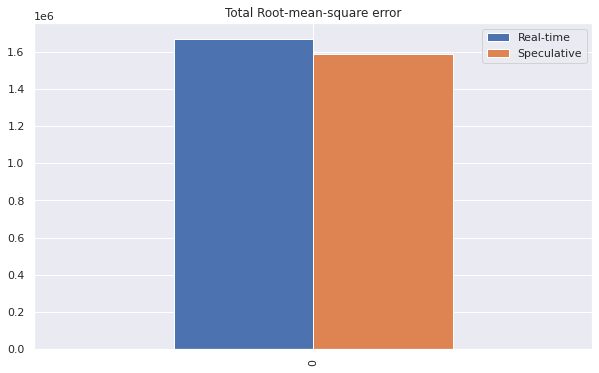

In [133]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 6)

results[['rfg_rt_rmse', 'rfg_speculative_rmse']].plot(kind='bar', ax=ax)
ax.set_title("Total Root-mean-square error")
ax.legend(["Real-time", "Speculative"])

In [134]:
results

rfg_rt_rmse  rfg_speculative_rmse
0  1.669380e+06          1.587612e+06

In [135]:
for col in results:
    print(col, '{0:.10f}'.format(results[col][0]))

rfg_rt_rmse 1669380.2633329662
rfg_speculative_rmse 1587612.1622681329
